Neural network to get galaxy type, Here only two types. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression

Getting the data. It are 43 fields. From 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26  degree in declination. 

In [2]:
cutouts1=np.load("stripe82_1_ell_spiral_im.npy")
cutouts2=np.load("stripe82_2_ell_spiral_im.npy")
cutouts3=np.load("stripe82_3_ell_spiral_im.npy")
cutouts4=np.load("stripe82_4_ell_spiral_im.npy")
cutouts5=np.load("stripe82_5_ell_spiral_im.npy")
cutouts6=np.load("stripe82_6_ell_spiral_im.npy")
cutouts7=np.load("stripe82_7_ell_spiral_im.npy")
cutouts8=np.load("stripe82_8_ell_spiral_im.npy")
cutouts9=np.load("stripe82_9_ell_spiral_im.npy")
cutouts10=np.load("stripe82_10_ell_spiral_im.npy")
cutouts11=np.load("stripe82_11_ell_spiral_im.npy")
cutouts12=np.load("stripe82_12_ell_spiral_im.npy")
cutouts13=np.load("stripe82_13_ell_spiral_im.npy")
cutouts14=np.load("stripe82_14_ell_spiral_im.npy")
cutouts15=np.load("stripe82_15_ell_spiral_im.npy")
cutouts16=np.load("stripe82_16_ell_spiral_im.npy")
cutouts17=np.load("stripe82_17_ell_spiral_im.npy")
cutouts18=np.load("stripe82_18_ell_spiral_im.npy")
cutouts19=np.load("stripe82_19_ell_spiral_im.npy")
cutouts20=np.load("stripe82_20_ell_spiral_im.npy")
cutouts21=np.load("stripe82_21_ell_spiral_im.npy")
cutouts22=np.load("stripe82_22_ell_spiral_im.npy")
cutouts23=np.load("stripe82_23_ell_spiral_im.npy")
cutouts24=np.load("stripe82_24_ell_spiral_im.npy")
cutouts25=np.load("stripe82_25_ell_spiral_im.npy")
cutouts26=np.load("stripe82_26_ell_spiral_im.npy")
cutouts27=np.load("stripe82_27_ell_spiral_im.npy")
cutouts28=np.load("stripe82_28_ell_spiral_im.npy")
cutouts29=np.load("stripe82_29_ell_spiral_im.npy")
cutouts30=np.load("stripe82_30_ell_spiral_im.npy")
cutouts31=np.load("stripe82_31_ell_spiral_im.npy")
cutouts32=np.load("stripe82_32_ell_spiral_im.npy")
cutouts33=np.load("stripe82_33_ell_spiral_im.npy")
cutouts34=np.load("stripe82_34_ell_spiral_im.npy")
cutouts35=np.load("stripe82_35_ell_spiral_im.npy")
cutouts36=np.load("stripe82_36_ell_spiral_im.npy")
cutouts37=np.load("stripe82_37_ell_spiral_im.npy")
cutouts38=np.load("stripe82_38_ell_spiral_im.npy")
cutouts39=np.load("stripe82_39_ell_spiral_im.npy")
cutouts40=np.load("stripe82_40_ell_spiral_im.npy")
cutouts41=np.load("stripe82_41_ell_spiral_im.npy")
cutouts42=np.load("stripe82_42_ell_spiral_im.npy")
cutouts43=np.load("stripe82_43_ell_spiral_im.npy")
print(cutouts1.shape)
#better a direct list later 
df1=pd.read_csv("stripe82_1_ell_spiral_table.csv")
df2=pd.read_csv("stripe82_2_ell_spiral_table.csv")
df3=pd.read_csv("stripe82_3_ell_spiral_table.csv")
df4=pd.read_csv("stripe82_4_ell_spiral_table.csv")
df5=pd.read_csv("stripe82_5_ell_spiral_table.csv")
df6=pd.read_csv("stripe82_6_ell_spiral_table.csv")
df7=pd.read_csv("stripe82_7_ell_spiral_table.csv")
df8=pd.read_csv("stripe82_8_ell_spiral_table.csv")
df9=pd.read_csv("stripe82_9_ell_spiral_table.csv")
df10=pd.read_csv("stripe82_10_ell_spiral_table.csv")
df11=pd.read_csv("stripe82_11_ell_spiral_table.csv")
df12=pd.read_csv("stripe82_12_ell_spiral_table.csv")
df13=pd.read_csv("stripe82_13_ell_spiral_table.csv")
df14=pd.read_csv("stripe82_14_ell_spiral_table.csv")
df15=pd.read_csv("stripe82_15_ell_spiral_table.csv")
df16=pd.read_csv("stripe82_16_ell_spiral_table.csv")
df17=pd.read_csv("stripe82_17_ell_spiral_table.csv")
df18=pd.read_csv("stripe82_18_ell_spiral_table.csv")
df19=pd.read_csv("stripe82_19_ell_spiral_table.csv")
df20=pd.read_csv("stripe82_20_ell_spiral_table.csv")
df21=pd.read_csv("stripe82_21_ell_spiral_table.csv")
df22=pd.read_csv("stripe82_22_ell_spiral_table.csv")
df23=pd.read_csv("stripe82_23_ell_spiral_table.csv")
df24=pd.read_csv("stripe82_24_ell_spiral_table.csv")
df25=pd.read_csv("stripe82_5_ell_spiral_table.csv")
df26=pd.read_csv("stripe82_6_ell_spiral_table.csv")
df27=pd.read_csv("stripe82_7_ell_spiral_table.csv")
df28=pd.read_csv("stripe82_8_ell_spiral_table.csv")
df29=pd.read_csv("stripe82_9_ell_spiral_table.csv")
df30=pd.read_csv("stripe82_10_ell_spiral_table.csv")
df31=pd.read_csv("stripe82_11_ell_spiral_table.csv")
df32=pd.read_csv("stripe82_12_ell_spiral_table.csv")
df33=pd.read_csv("stripe82_13_ell_spiral_table.csv")
df14=pd.read_csv("stripe82_14_ell_spiral_table.csv")
df15=pd.read_csv("stripe82_15_ell_spiral_table.csv")
df16=pd.read_csv("stripe82_16_ell_spiral_table.csv")
df17=pd.read_csv("stripe82_17_ell_spiral_table.csv")
df18=pd.read_csv("stripe82_18_ell_spiral_table.csv")
df19=pd.read_csv("stripe82_19_ell_spiral_table.csv")
df20=pd.read_csv("stripe82_20_ell_spiral_table.csv")
df21=pd.read_csv("stripe82_21_ell_spiral_table.csv")
df22=pd.read_csv("stripe82_22_ell_spiral_table.csv")
df23=pd.read_csv("stripe82_23_ell_spiral_table.csv")
df24=pd.read_csv("stripe82_24_ell_spiral_table.csv")
df25=pd.read_csv("stripe82_25_ell_spiral_table.csv")
df26=pd.read_csv("stripe82_26_ell_spiral_table.csv")
df27=pd.read_csv("stripe82_27_ell_spiral_table.csv")
df28=pd.read_csv("stripe82_28_ell_spiral_table.csv")
df29=pd.read_csv("stripe82_29_ell_spiral_table.csv")
df30=pd.read_csv("stripe82_30_ell_spiral_table.csv")
df31=pd.read_csv("stripe82_31_ell_spiral_table.csv")
df32=pd.read_csv("stripe82_32_ell_spiral_table.csv")
df33=pd.read_csv("stripe82_33_ell_spiral_table.csv")
df34=pd.read_csv("stripe82_34_ell_spiral_table.csv")
df35=pd.read_csv("stripe82_35_ell_spiral_table.csv")
df36=pd.read_csv("stripe82_36_ell_spiral_table.csv")
df37=pd.read_csv("stripe82_37_ell_spiral_table.csv")
df38=pd.read_csv("stripe82_38_ell_spiral_table.csv")
df39=pd.read_csv("stripe82_39_ell_spiral_table.csv")
df40=pd.read_csv("stripe82_40_ell_spiral_table.csv")
df41=pd.read_csv("stripe82_41_ell_spiral_table.csv")
df42=pd.read_csv("stripe82_42_ell_spiral_table.csv")
df43=pd.read_csv("stripe82_43_ell_spiral_table.csv")
print(df1.columns)

(43, 43, 1, 168)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image'],
      dtype='object')


Now I built the function to combine the four numpy arrays.

In [3]:
#combines numpy arrays of 4d shape, same shape first 3, last variable
def comb_nump_4d(input_list):
    l=0
    for i in range(len(input_list)):
        l+=input_list[i].shape[3]
    combined=np.zeros((input_list[0].shape[0],input_list[0].shape[1],input_list[0].shape[2],l))
    l=0
    for i in range(len(input_list)):
        combined[:,:,:,l:l+input_list[i].shape[3]]=input_list[i]
        l+=input_list[i].shape[3]  
    return combined

Combining the images. 

In [4]:
cutout_lists=[cutouts1,cutouts2,cutouts3,cutouts4,cutouts5,cutouts6,cutouts7,cutouts8,cutouts9,cutouts10,cutouts11,cutouts12,cutouts13,cutouts14,cutouts15,cutouts16,cutouts17,cutouts18,cutouts19,cutouts20,cutouts21,cutouts22,cutouts23,cutouts24,cutouts25,cutouts26,cutouts27,cutouts28,cutouts29,cutouts30,cutouts31,cutouts32,cutouts33,cutouts34,cutouts35,cutouts36,cutouts37,cutouts38,cutouts39,cutouts40,cutouts41,cutouts42,cutouts43]
cutouts=comb_nump_4d(cutout_lists)

Now combining the data frames with the classfications and more meta data. 

In [5]:
df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,df19,df20,df21,df22,df23,df24,df25,df26,df27,df28,df29,df30,df31,df32,df33,df34,df35,df36,df37,df38,df39,df40,df41,df42,df43],ignore_index=True)
print(df1.head(),df.head(),df43.tail(),df.tail())

   Unnamed: 0  index                objid         ra       dec  psfMag_u  \
0           0      1  1237663237128388701  50.130513 -1.228488  22.01211   
1           1    123  1237666299481817102  50.160628 -1.035026  19.01124   
2           2    140  1237663237128388949  50.167304 -1.241885  22.36878   
3           3    458  1237666300018557091  50.006004 -0.495751  21.98376   
4           4    110  1237663238739067202  50.387910  0.198944  21.86834   

   psfMag_g  psfMag_r  psfMag_i  psfMag_z  ...   p_mg  p_el_debiased  \
0  20.06700  18.86854  18.35853  17.93478  ...  0.032          0.935   
1  17.46116  16.85288  16.54355  16.19304  ...  0.000          0.971   
2  20.17246  18.94735  18.44240  17.99196  ...  0.000          0.964   
3  19.93291  18.73658  18.31895  17.89719  ...  0.000          0.893   
4  19.78908  18.63620  18.16101  17.63892  ...  0.018          0.755   

   p_cs_debiased  spiral  elliptical  uncertain  image      pixel_x  \
0          0.000       0           1   

Has worked, now looking on classes. 

In [6]:
print(df.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


Somewhat inbalanced, clearly more spirals than ellipctical galaxies.
 
Now adding columns to data frame that also other algorithms can work on it. 

In [7]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1
print(df)        

/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

      Unnamed: 0  index                objid          ra       dec  psfMag_u  \
0              0      1  1237663237128388701   50.130513 -1.228488  22.01211   
1              1    123  1237666299481817102   50.160628 -1.035026  19.01124   
2              2    140  1237663237128388949   50.167304 -1.241885  22.36878   
3              3    458  1237666300018557091   50.006004 -0.495751  21.98376   
4              4    110  1237663238739067202   50.387910  0.198944  21.86834   
...          ...    ...                  ...         ...       ...       ...   
7870         101    101  1237663543675126583  312.305638  0.325466  21.65428   
7871         102    243  1237663543675060734  312.252401  0.351028  21.40535   
7872         103    257  1237678596459004706  312.353091  0.906897  20.69301   
7873         104    263  1237678596459070093  312.482143  0.899587  20.42247   
7874         105      8  1237678617933840840  312.415661  0.836877  21.30678   

      psfMag_g  psfMag_r  psfMag_i  psf

/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_9145/748454094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

In [8]:
print(df.columns[51],df.columns[1899])

0 1848


Now starting with torch spefifics. 

In [9]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [10]:
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)
print(feature_test)

shape of image train data
(4725, 1, 43, 43)
           0          1          2          3          4          5     \
7250  -0.671509  -0.270374   0.568258   0.748187   0.106514   0.491256   
2896  14.361377  15.999631  15.021544  14.212921  16.437111  18.469778   
3329   1.400726   0.407343   0.848358   1.608956   1.318081   1.688733   
6120   1.741505   0.490504   0.683172   1.506649   1.003500   1.217041   
2842   1.038349   0.094624   1.703698   1.768898   0.666397   2.107406   
...         ...        ...        ...        ...        ...        ...   
7565  -0.421559   0.220490  -0.020975  -0.416924  -0.335829   1.411871   
551    7.063395   7.432566   7.274216   7.202036   6.730490   6.429748   
6019   1.913022   1.897351   3.837757   3.496063   2.804465   3.033000   
1625   0.714121   0.846052   0.592803   1.055074   0.230322   0.947309   
3707  24.069626  27.446905  30.535490  31.509089  31.743973  33.973873   

           6          7          8          9     ...       1839   

Now creating multiple entries for each by mirroring and rotations. First make image of the first without. 

(4725, 1, 43, 43)


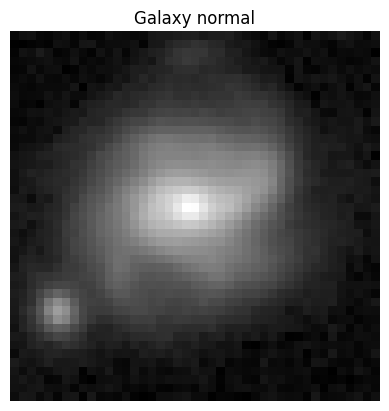

In [11]:
print(image_train.shape)
plt.axis('off')
plt.title("Galaxy normal")
plt.imshow(abs(image_train[2,0,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

Thus getting all 7 other apparences means 3 rotations on original and flip on original 3 rotations on it. That are in total 8. 

In [12]:
def get_rot_mirror_square(dat):
    if dat.shape[0]!=dat.shape[1]:
        print("Data is not a square")
    else:
        res=np.zeros((8,dat.shape[0],dat.shape[1]))
        res[0,:,:]=dat
        res[4,:,:]=np.flip(dat,0)
        for i in range(3):
            res[1+i,:,:]=np.rot90(dat,k=i+1,axes=(0,1))
            res[5+i,:,:]=np.rot90(res[4,:,:],k=i+1,axes=(0,1))
        return res    

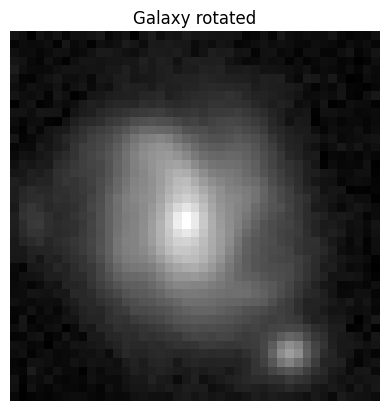

In [13]:
all_rots=get_rot_mirror_square(image_train[2,0,:,:])

plt.axis('off')
plt.title("Galaxy rotated")
plt.imshow(abs(all_rots[1,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

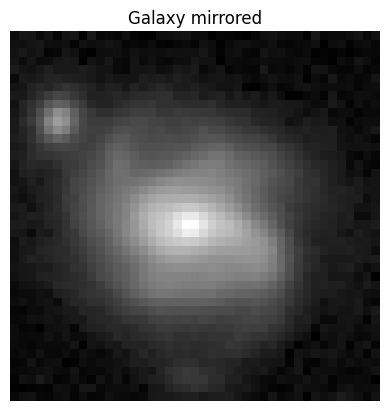

In [14]:
plt.axis('off')
plt.title("Galaxy mirrored")
plt.imshow(abs(all_rots[4,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

All work.

In [15]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

In [16]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [17]:
target_train, target_test = np.array(target_train), np.array(target_test)
feature_train, feature_test = np.array(feature_train), np.array(feature_test)


In [18]:
BATCH_SIZE=32

In [19]:
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())


In [20]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)

Perceptron network. 4 layers tried. 

In [21]:
#now 4 layers 
#two output options only 
class BinaryClassification4(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification4, self).__init__()
        self.fc1 = nn.Linear(num_features, 300)
        self.fc2 = nn.Linear(300, 100)  
        self.fc3 = nn.Linear(100, 30)        
        self.fc4 = nn.Linear(30, 10)   
        self.fc5 = nn.Linear(10, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))        
        x = torch.sigmoid(self.fc5(x))
        return (x)

Now trying smaller networks, likely the data is too noisy and not large enough that the standard amount works.

In [22]:
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 1849

In [23]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect stats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0,silent=False):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)  
    if silent==False:    
        print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
        if silent==False:
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

In [24]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [51]:
# 2 116 12 | 116 182 test 71 71 | 76 130 
# 4  46 82 | 21 277 test  30 48 | 18 188
# seems to restart at each trail 
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("4 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)
#some have 124 4 18 280 in train, test: 70 8 32 174
#now 16 samples, 40 epochs, train  256 38 81 711 
#now with 200 got into one sided train 0 454 0 1175

4 layer perceptron
train
[[ 697    0]
 [1989    0]]
test
[[ 521    0]
 [1271    0]]


Text(0, 0.5, 'BCE loss')

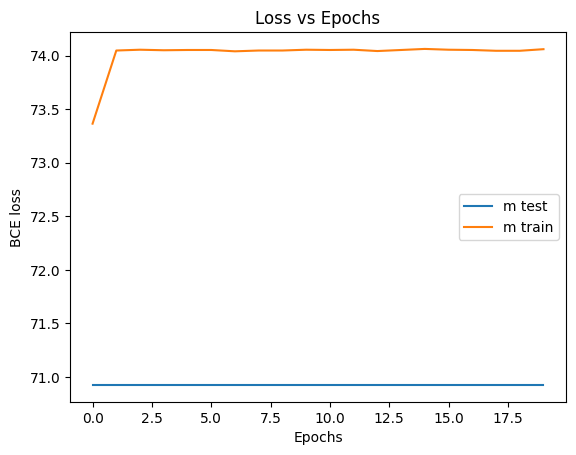

In [58]:
plt.plot(loss_stats_m['test'],label='m test')
plt.plot(loss_stats_m['train'],label='m train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

Now I other other method for classification, first XGBoost. 

In [36]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

In [38]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)
#16 test was 247 47 \ 55 737
#24 test was 440 61  \ 81 1210
#43 test it 753 117 / 116 2164

confusion matrix xgboost train
[[1238    1]
 [   0 3486]]
confusion matrix xgboost test
[[ 753  117]
 [ 116 2164]]


Xgboost works approximately with standard settings. Likely it can be improved because the train set is perfectly classified and thus thus clearly overfit. 

Now I try logistic. I really high number of iterations is needed, scaling features would help, but then regularization is more more random. 

In [39]:

lc1=LogisticRegression(max_iter=6000,penalty='none').fit(feature_train,target_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)
#16 test  169 125 \ 245 547
#24 test  276 245 \ 349 922 gets worse in the minor class,better in the main 
#43 test  478 392\ 540 11740 now again getting better

confusion matrix logistic regression train
[[1205   34]
 [  20 3466]]
confusion matrix logistic regression test
[[ 478  392]
 [ 540 1740]]


Logistic works less good as xgboost and does not improve clearlz with more data. Means that wrong features are fit then. Both should improve with regularization. 

In [41]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [42]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)
np.savetxt("xgb_43sets_gal-type_v1.txt",stats_xgb)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.49353212e-01 2.56598174e-03
  2.24211778e-01]
 [3.00000000e-04 1.00000000e+00 9.51422319e-01 2.45484942e-03
  2.22394796e-01]
 [1.00000000e-03 9.99856590e-01 9.48381452e-01 2.58556133e-03
  2.22074409e-01]
 [3.00000000e-03 1.00000000e+00 9.49901553e-01 2.57140657e-03
  2.22985242e-01]
 [1.00000000e-02 1.00000000e+00 9.49725576e-01 2.52495030e-03
  2.17790500e-01]
 [3.00000000e-02 9.99856590e-01 9.52234882e-01 2.57514407e-03
  2.19505732e-01]
 [1.00000000e-01 9.99856590e-01 9.

Is now rather slow with the full data set. 

Now defining function to do the regularization loop for logistic. 

In [47]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}") #does not always converge but are cases which are certainly not useful ones
        xc1=LogisticRegression(max_iter=10000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [48]:
regs=[0.0000000001,0.000000003,0.00000001,0.00000003,0.0000001,0.0000003,0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
print(regs)
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
print(np.round(stats_log.T,5))
np.savetxt("log_43sets_gal-type_v1.txt",stats_log)

[1e-10, 3e-09, 1e-08, 3e-08, 1e-07, 3e-07, 1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
doing l2 regularization 1e-10
doing l2 regularization 3e-09
doing l2 regularization 1e-08
doing l2 regularization 3e-08
doing l2 regularization 1e-07
doing l2 regularization 3e-07
doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.3


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 1


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 3


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 10


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 30


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 100
[[0.00000e+00 8.49290e-01 8.43020e-01 5.53090e-01 5.62540e-01]
 [0.00000e+00 8.66870e-01 8.60600e-01 4.75930e-01 4.89510e-01]
 [0.00000e+00 8.69120e-01 8.61830e-01 4.45890e-01 4.66340e-01]
 [0.00000e+00 8.67910e-01 8.57430e-01 4.29210e-01 4.56010e-01]
 [0.00000e+00 8.65360e-01 8.52830e-01 4.19210e-01 4.51130e-01]
 [0.00000e+00 8.66680e-01 8.53500e-01 4.13000e-01 4.49790e-01]
 [0.00000e+00 8.67930e-01 8.49400e-01 4.07050e-01 4.53330e-01]
 [0.00000e+00 8.70310e-01 8.46850e-01 4.00760e-01 4.63900e-01]
 [1.00000e-05 8.71310e-01 8.44620e-01 3.91520e-01 4.92460e-01]
 [3.00000e-05 8.76320e-01 8.45540e-01 3.80150e-01 5.30800e-01]
 [1.00000e-04 8.85370e-01 8.42300e-01 3.62930e-01 5.76390e-01]
 [3.00000e-04 8.94820e-01 8.44190e-01 3.39190e-01 6.03090e-01]
 [1.00000e-03 9.11470e-01 8.41570e-01 2.98990e-01 6.63140e-01]
 [3.00000e-03 9.32760e-01 8.39780e-01 2.51760e-01 7.81500e-01]
 [1.00000e-02 9.54470e-01 8.28860e-01 1.97970e-01 9.58160e-01]
 [3.00000e-02 9.67910e-01 8

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now plotting both, first f1 score. 

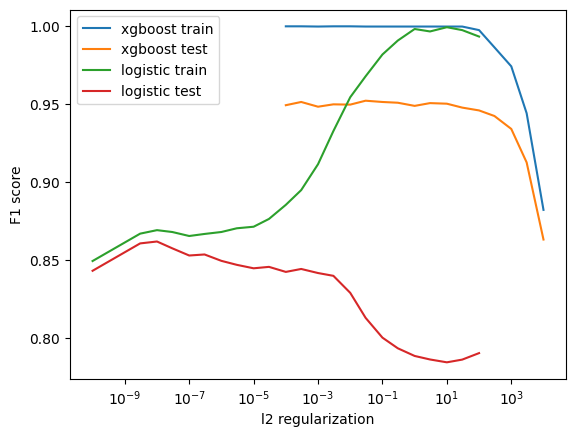

In [50]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_v1.txt")
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

Then log loss. 

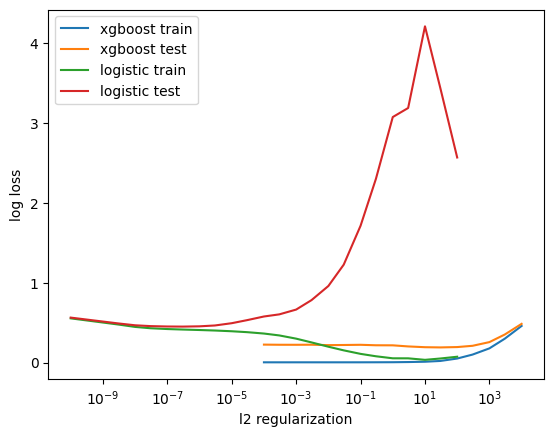

In [51]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")

Probably none convergence cuases change at high high l, but not relevant for sure not best model. 

Xgboost is clearly better. It is in the not so much data limit where adding regularziation is not clearly improving test at F1 score. Below I zoom into log loss to see whether there is a minimum.

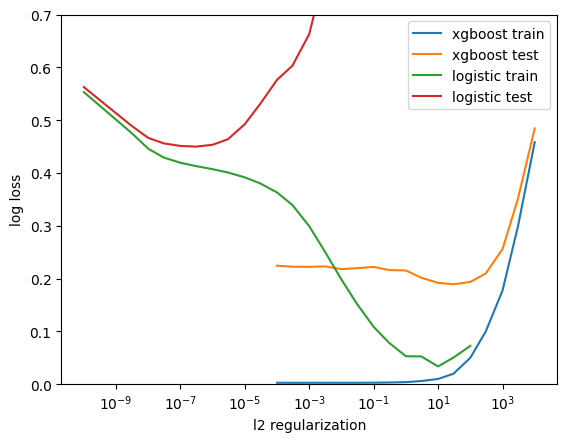

In [52]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.ylim(0,0.7)
plt.xscale("log")

There is one now at not extactly the same position as the local maximum in the F1 score. For linear there is also a minimum now visible, a clearly worse, but still better than a constant probability, similar as to xgboost the local shifts compared to the local maximum in the F1 score.  That shifting is bot ideal, I should likely add rotations mirrorring versions for fitting in any case but is unlikely to solve the main torch problem since it only incrtease the data amount by a factor 8 even if there is no more fundamental problem in torch, which is not clear. Still similar with 24 data sets, it only looks slowly better.

Test input outputs relations for convolutional network of 3 convolutional layers, it is still 3 *3 convolutional and 2 *2 maximuma.

In [53]:
input0 = torch.randn(1, 1, 43, 43)
b=torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
output0=b(input0)
print(f"first conv layer input: {input0.shape} output: {output0.shape}")

m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
output1 = m(output0)
print(f"max pool input:{output0.shape} output:{output1.shape}")
#input format (Batch, Number Channels, height, width)
b2=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)

output2=b2(output1)
print(f"second conv layer input: {output1.shape} output: {output2.shape}")
output3 = m(output2)
print(f"second max pool layer input: {output2.shape} output: {output3.shape}")

b3=torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)

output4=b3(output3)
print(f"third conv layer input: {output3.shape} output: {output4.shape}")
output5 = m(output4)
print(f"third max pool layer input: {output4.shape} output: {output5.shape}")

first conv layer input: torch.Size([1, 1, 43, 43]) output: torch.Size([1, 16, 41, 41])
max pool input:torch.Size([1, 16, 41, 41]) output:torch.Size([1, 16, 20, 20])
second conv layer input: torch.Size([1, 16, 20, 20]) output: torch.Size([1, 32, 18, 18])
second max pool layer input: torch.Size([1, 32, 18, 18]) output: torch.Size([1, 32, 9, 9])
third conv layer input: torch.Size([1, 32, 9, 9]) output: torch.Size([1, 64, 7, 7])
third max pool layer input: torch.Size([1, 64, 7, 7]) output: torch.Size([1, 64, 3, 3])


In [25]:
class CNNBinary4(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary4, self).__init__()
        # L1 ImgIn shape=(?, 43, 43, 1)
        # Conv -> (?, 41, 41, 16)
        # Pool -> (?, 20, 20, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 20, 20, 16)
        # Conv      ->(?, 18, 18, 32)
        # Pool      ->(?, 9, 9, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 9, 9, 32)
        # Conv      ->(?, 7, 7, 64)
        # Pool      ->(?, 3, 3, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))        
        # L3 FC 3x3x64 inputs -> 128 outputs
        self.fc1 = torch.nn.Linear(3 * 3 * 64, 128, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight) #old
        #nn.init.xavier_uniform_.torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 128 inputs -> 1 output
        self.fc2 = torch.nn.Linear(128, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        #nn.init.xavier_uniform_.torch.nn.init.xavier_uniform(self.fc1.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) #dont forget to add/omit layer here
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))       
        return out

In [26]:
#that are stars could be added as class, but likely only in other notebook 
cutouts_s1=np.load("stripe82_1_stars_im.npy")
cutouts_s2=np.load("stripe82_2_stars_im.npy")
cutouts_s3=np.load("stripe82_3_stars_im.npy")
cutouts_s4=np.load("stripe82_4_stars_im.npy")
print(cutouts_s1.shape,cutouts_s2.shape,cutouts_s3.shape,cutouts_s4.shape)

(43, 43, 1, 613) (43, 43, 1, 795) (43, 43, 1, 831) (43, 43, 1, 621)


Now same set up new network and data.

In [102]:
keep_prob=1
model2c =CNNBinary4()
model2c.to(device)
print(model2c)
loss_stats_st11c = {
    'train': [], 'test': []
}
torch_fit(model2c,train_im_loader,test_im_loader,40,32,0.001,loss_stats_st11c)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Begin training.


/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.78817 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 007: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 008: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 009: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 010: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 011: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 012: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 013: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 014: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 015: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 016: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 017: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 018: | Train Loss: 25.94990 | Test Loss: 2

Does not work in 1,2, 3,4 5,trials. 

In [56]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

Now loop with different regularizations. 

In [132]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
stats_4cn=run_loop_torch(CNNBinary4,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,200,64,0.001,regs)
np.savetxt("conv2d_4n_v1_gal_200.txt",stats_4cn)

running reg of 0.0001
Begin training.


/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 72.72895 | Test Loss: 70.89854
Epoch 002: | Train Loss: 74.05754 | Test Loss: 70.89962
Epoch 003: | Train Loss: 74.05754 | Test Loss: 70.90014
Epoch 004: | Train Loss: 74.04762 | Test Loss: 70.90043
Epoch 005: | Train Loss: 74.05506 | Test Loss: 70.90062
Epoch 006: | Train Loss: 74.05506 | Test Loss: 70.90075
Epoch 007: | Train Loss: 74.05010 | Test Loss: 70.90080
Epoch 008: | Train Loss: 74.05010 | Test Loss: 70.90079
Epoch 009: | Train Loss: 74.05258 | Test Loss: 70.90072
Epoch 010: | Train Loss: 74.05506 | Test Loss: 70.90062
Epoch 011: | Train Loss: 74.04266 | Test Loss: 70.90048
Epoch 012: | Train Loss: 74.05010 | Test Loss: 70.90031
Epoch 013: | Train Loss: 74.06002 | Test Loss: 70.90011
Epoch 014: | Train Loss: 74.04266 | Test Loss: 70.89989
Epoch 015: | Train Loss: 74.06002 | Test Loss: 70.89963
Epoch 016: | Train Loss: 74.05754 | Test Loss: 70.89934
Epoch 017: | Train Loss: 74.05258 | Test Loss: 70.89902
Epoch 018: | Train Loss: 74.05506 | Test Loss: 7

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.69725 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.95982 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 007: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 008: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 009: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 010: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 011: | Train Loss: 25.93750 | Test Loss: 29.07366
Epoch 012: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 013: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 014: | Train Loss: 25.96230 | Test Loss: 29.07366
Epoch 015: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 016: | Train Loss: 25.95982 | Test Loss: 29.07366
Epoch 017: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 018: | Train Loss: 25.94990 | Test Loss: 2

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.04601 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.96478 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.93750 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 007: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 008: | Train Loss: 25.96230 | Test Loss: 29.07366
Epoch 009: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 010: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 011: | Train Loss: 25.93750 | Test Loss: 29.07366
Epoch 012: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 013: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 014: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 015: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 016: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 017: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 018: | Train Loss: 25.95982 | Test Loss: 2

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.79541 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.93998 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 007: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 008: | Train Loss: 25.95982 | Test Loss: 29.07366
Epoch 009: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 010: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 011: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 012: | Train Loss: 25.95982 | Test Loss: 29.07366
Epoch 013: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 014: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 015: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 016: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 017: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 018: | Train Loss: 25.94742 | Test Loss: 2

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.82339 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.96726 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 007: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 008: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 009: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 010: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 011: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 012: | Train Loss: 25.95734 | Test Loss: 29.07366
Epoch 013: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 014: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 015: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 016: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 017: | Train Loss: 25.94990 | Test Loss: 29.07366
Epoch 018: | Train Loss: 25.95238 | Test Loss: 2

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.40148 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 006: | Train Loss: 18.40362 | Test Loss: 0.58268
Epoch 007: | Train Loss: 0.48716 | Test Loss: 0.45691
Epoch 008: | Train Loss: 0.37295 | Test Loss: 0.48901
Epoch 009: | Train Loss: 0.31355 | Test Loss: 0.26517
Epoch 010: | Train Loss: 0.24882 | Test Loss: 0.26673
Epoch 011: | Train Loss: 0.23503 | Test Loss: 0.23348
Epoch 012: | Train Loss: 0.25046 | Test Loss: 0.21467
Epoch 013: | Train Loss: 0.21651 | Test Loss: 0.21482
Epoch 014: | Train Loss: 0.22453 | Test Loss: 0.21701
Epoch 015: | Train Loss: 0.19486 | Test Loss: 0.20144
Epoch 016: | Train Loss: 0.19812 | Test Loss: 0.19882
Epoch 017: | Train Loss: 0.19776 | Test Loss: 0.21919
Epoch 018: | Train Loss: 0.20300 | Test Loss: 0.26643
Epoch 019: | Trai

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.84004 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.95238 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.94742 | Test Loss: 29.07366
Epoch 004: | Train Loss: 25.94246 | Test Loss: 29.07366
Epoch 005: | Train Loss: 25.94494 | Test Loss: 29.07366
Epoch 006: | Train Loss: 25.94246 | Test Loss: 29.02675
Epoch 007: | Train Loss: 15.43619 | Test Loss: 0.56144
Epoch 008: | Train Loss: 0.47514 | Test Loss: 0.43651
Epoch 009: | Train Loss: 0.43396 | Test Loss: 0.40796
Epoch 010: | Train Loss: 0.40408 | Test Loss: 0.35545
Epoch 011: | Train Loss: 0.42279 | Test Loss: 0.37019
Epoch 012: | Train Loss: 0.39300 | Test Loss: 0.38045
Epoch 013: | Train Loss: 0.39017 | Test Loss: 0.36099
Epoch 014: | Train Loss: 0.38140 | Test Loss: 0.34716
Epoch 015: | Train Loss: 0.39298 | Test Loss: 0.34541
Epoch 016: | Train Loss: 0.37137 | Test Loss: 0.32291
Epoch 017: | Train Loss: 0.41941 | Test Loss: 0.32451
Epoch 018: | Train Loss: 0.36609 | Test Loss: 0.40017
Epoch 019: | Tr

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.79260 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.54990 | Test Loss: 10.04900
Epoch 003: | Train Loss: 0.94811 | Test Loss: 0.54735
Epoch 004: | Train Loss: 0.52408 | Test Loss: 0.49357
Epoch 005: | Train Loss: 0.58657 | Test Loss: 0.57352
Epoch 006: | Train Loss: 0.53532 | Test Loss: 0.51367
Epoch 007: | Train Loss: 0.50068 | Test Loss: 0.49159
Epoch 008: | Train Loss: 0.47992 | Test Loss: 0.48967
Epoch 009: | Train Loss: 0.46870 | Test Loss: 0.46737
Epoch 010: | Train Loss: 0.45523 | Test Loss: 0.46873
Epoch 011: | Train Loss: 0.46068 | Test Loss: 0.46332
Epoch 012: | Train Loss: 0.50645 | Test Loss: 0.47917
Epoch 013: | Train Loss: 0.45674 | Test Loss: 0.47425
Epoch 014: | Train Loss: 0.48812 | Test Loss: 0.45866
Epoch 015: | Train Loss: 0.48696 | Test Loss: 0.44552
Epoch 016: | Train Loss: 0.45721 | Test Loss: 0.44271
Epoch 017: | Train Loss: 0.46357 | Test Loss: 0.44395
Epoch 018: | Train Loss: 0.48709 | Test Loss: 0.44128
Epoch 019: | Train Loss:

/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.80839 | Test Loss: 25.84713
Epoch 002: | Train Loss: 1.82224 | Test Loss: 0.58842
Epoch 003: | Train Loss: 0.57560 | Test Loss: 0.63237
Epoch 004: | Train Loss: 0.59934 | Test Loss: 0.60675
Epoch 005: | Train Loss: 0.61033 | Test Loss: 0.62189
Epoch 006: | Train Loss: 0.61746 | Test Loss: 0.63183
Epoch 007: | Train Loss: 0.61832 | Test Loss: 0.63568
Epoch 008: | Train Loss: 0.63660 | Test Loss: 0.65553
Epoch 009: | Train Loss: 0.64716 | Test Loss: 0.65795
Epoch 010: | Train Loss: 0.65225 | Test Loss: 0.65827
Epoch 011: | Train Loss: 0.65189 | Test Loss: 0.65785
Epoch 012: | Train Loss: 0.65199 | Test Loss: 0.65747
Epoch 013: | Train Loss: 0.65104 | Test Loss: 0.65737
Epoch 014: | Train Loss: 0.65174 | Test Loss: 0.65792
Epoch 015: | Train Loss: 0.65181 | Test Loss: 0.65732
Epoch 016: | Train Loss: 0.65090 | Test Loss: 0.65791
Epoch 017: | Train Loss: 0.65170 | Test Loss: 0.65742
Epoch 018: | Train Loss: 0.65178 | Test Loss: 0.65742
Epoch 019: | Train Loss: 0

It now works sometimes (in run with 10), but lots of chance and not often. 

In [128]:
stats_4n_10=np.loadtxt("conv2d_4n_v1_gal_10.txt")
stats_4n_20=np.loadtxt("conv2d_4n_v1_gal_20.txt")
stats_4n_30=np.loadtxt("conv2d_4n_v1_gal_30.txt")
stats_4n_40=np.loadtxt("conv2d_4n_v1_gal_40.txt")
stats_4n_60=np.loadtxt("conv2d_4n_v1_gal_60.txt")
stats_4n_100=np.loadtxt("conv2d_4n_v1_gal_100.txt")

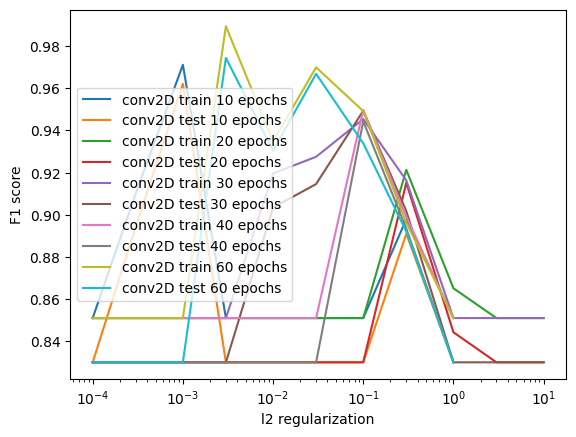

In [129]:
plt.plot(stats_4n_10[0],stats_4n_10[1],label='conv2D train 10 epochs')
plt.plot(stats_4n_10[0],stats_4n_10[2],label='conv2D test 10 epochs')
plt.plot(stats_4n_20[0],stats_4n_20[1],label='conv2D train 20 epochs')
plt.plot(stats_4n_20[0],stats_4n_20[2],label='conv2D test 20 epochs')
plt.plot(stats_4n_30[0],stats_4n_30[1],label='conv2D train 30 epochs')
plt.plot(stats_4n_30[0],stats_4n_30[2],label='conv2D test 30 epochs')
plt.plot(stats_4n_40[0],stats_4n_40[1],label='conv2D train 40 epochs')
plt.plot(stats_4n_40[0],stats_4n_40[2],label='conv2D test 40 epochs')
plt.plot(stats_4n_60[0],stats_4n_60[1],label='conv2D train 60 epochs')
plt.plot(stats_4n_60[0],stats_4n_60[2],label='conv2D test 60 epochs')
#plt.plot(per_stats[0],per_stats[1],label='perceptron train')
#plt.plot(per_stats[0],per_stats[2],label='perceptron test')
#plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
#plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
#plt.plot(stats_log[0],stats_log[1],label='logistic train')
#plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")

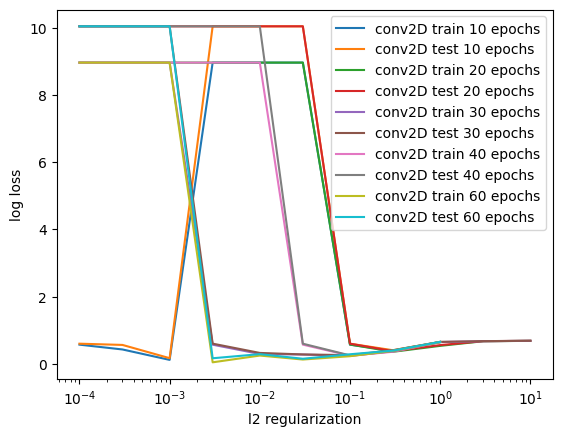

In [130]:
plt.plot(stats_4n_10[0],stats_4n_10[3],label='conv2D train 10 epochs')
plt.plot(stats_4n_10[0],stats_4n_10[4],label='conv2D test 10 epochs')
plt.plot(stats_4n_20[0],stats_4n_20[3],label='conv2D train 20 epochs')
plt.plot(stats_4n_20[0],stats_4n_20[4],label='conv2D test 20 epochs')
plt.plot(stats_4n_30[0],stats_4n_30[3],label='conv2D train 30 epochs')
plt.plot(stats_4n_30[0],stats_4n_30[4],label='conv2D test 30 epochs')
plt.plot(stats_4n_40[0],stats_4n_40[3],label='conv2D train 40 epochs')
plt.plot(stats_4n_40[0],stats_4n_40[4],label='conv2D test 40 epochs')
plt.plot(stats_4n_60[0],stats_4n_60[3],label='conv2D train 60 epochs')
plt.plot(stats_4n_60[0],stats_4n_60[4],label='conv2D test 60 epochs')
#plt.plot(per_stats[0],per_stats[1],label='perceptron train')
#plt.plot(per_stats[0],per_stats[2],label='perceptron test')
#plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
#plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
#plt.plot(stats_log[0],stats_log[1],label='logistic train')
#plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")

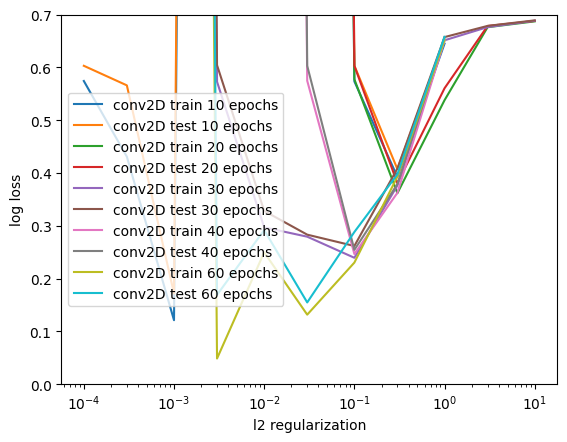

In [131]:
plt.plot(stats_4n_10[0],stats_4n_10[3],label='conv2D train 10 epochs')
plt.plot(stats_4n_10[0],stats_4n_10[4],label='conv2D test 10 epochs')
plt.plot(stats_4n_20[0],stats_4n_20[3],label='conv2D train 20 epochs')
plt.plot(stats_4n_20[0],stats_4n_20[4],label='conv2D test 20 epochs')
plt.plot(stats_4n_30[0],stats_4n_30[3],label='conv2D train 30 epochs')
plt.plot(stats_4n_30[0],stats_4n_30[4],label='conv2D test 30 epochs')
plt.plot(stats_4n_40[0],stats_4n_40[3],label='conv2D train 40 epochs')
plt.plot(stats_4n_40[0],stats_4n_40[4],label='conv2D test 40 epochs')
plt.plot(stats_4n_60[0],stats_4n_60[3],label='conv2D train 60 epochs')
plt.plot(stats_4n_60[0],stats_4n_60[4],label='conv2D test 60 epochs')
#plt.plot(per_stats[0],per_stats[1],label='perceptron train')
#plt.plot(per_stats[0],per_stats[2],label='perceptron test')
#plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
#plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
#plt.plot(stats_log[0],stats_log[1],label='logistic train')
#plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.ylim(0,0.7)
plt.xscale("log")

Larger regularizations seem easier. Could I first converge them and then do lower regularization after them? 
Or just enough iterations? 

In [133]:
keep_prob=1
model2d =CNNBinary4()
model2d.to(device)
print(model2d)
loss_stats_st13c = {
    'train': [], 'test': []
}
torch_fit(model2d,train_im_loader,test_im_loader,20,32,0.001,loss_stats_st13c,l2reg=0.3)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Begin training.


/tmp/ipykernel_7354/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.65726 | Test Loss: 29.07366
Epoch 002: | Train Loss: 25.95486 | Test Loss: 29.07366
Epoch 003: | Train Loss: 25.94246 | Test Loss: 28.88298
Epoch 004: | Train Loss: 5.47718 | Test Loss: 0.59840
Epoch 005: | Train Loss: 0.53514 | Test Loss: 0.64067
Epoch 006: | Train Loss: 0.50466 | Test Loss: 0.48764
Epoch 007: | Train Loss: 0.48186 | Test Loss: 0.47579
Epoch 008: | Train Loss: 0.48006 | Test Loss: 0.44913
Epoch 009: | Train Loss: 0.48922 | Test Loss: 0.44529
Epoch 010: | Train Loss: 0.43970 | Test Loss: 0.43822
Epoch 011: | Train Loss: 0.42329 | Test Loss: 0.46944
Epoch 012: | Train Loss: 0.42354 | Test Loss: 0.45990
Epoch 013: | Train Loss: 0.40717 | Test Loss: 0.41859
Epoch 014: | Train Loss: 0.42246 | Test Loss: 0.56069
Epoch 015: | Train Loss: 0.40527 | Test Loss: 0.55910
Epoch 016: | Train Loss: 0.41832 | Test Loss: 0.41758
Epoch 017: | Train Loss: 0.41731 | Test Loss: 0.52758
Epoch 018: | Train Loss: 0.42020 | Test Loss: 0.39783
Epoch 019: | Train Los

In [134]:
torch_fit(model2d,train_im_loader,test_im_loader,20,32,0.001,loss_stats_st13c,l2reg=0.003)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.34432 | Test Loss: 0.38405
Epoch 002: | Train Loss: 0.29512 | Test Loss: 0.35253
Epoch 003: | Train Loss: 0.28508 | Test Loss: 0.35266
Epoch 004: | Train Loss: 0.28737 | Test Loss: 0.33186
Epoch 005: | Train Loss: 0.26562 | Test Loss: 0.38826
Epoch 006: | Train Loss: 0.26077 | Test Loss: 0.33396
Epoch 007: | Train Loss: 0.24928 | Test Loss: 0.31533
Epoch 008: | Train Loss: 0.24441 | Test Loss: 0.35679
Epoch 009: | Train Loss: 0.25514 | Test Loss: 0.33250
Epoch 010: | Train Loss: 0.26221 | Test Loss: 0.25874
Epoch 011: | Train Loss: 0.23147 | Test Loss: 0.25127
Epoch 012: | Train Loss: 0.22445 | Test Loss: 0.23774
Epoch 013: | Train Loss: 0.23151 | Test Loss: 0.24768
Epoch 014: | Train Loss: 0.23545 | Test Loss: 0.22776
Epoch 015: | Train Loss: 0.20923 | Test Loss: 0.26603
Epoch 016: | Train Loss: 0.19086 | Test Loss: 0.21809
Epoch 017: | Train Loss: 0.18970 | Test Loss: 0.21018
Epoch 018: | Train Loss: 0.19626 | Test Loss: 0.21812
Epoch 019: | Train Loss: 0.2

In [ ]:
That works, thus I should implement that. 

In [28]:
def run_loop_torch2(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        #first with large regularization 
        print(f"initial run of high regularization")
        torch_fit(model3,train,test,20,batch,alpha,loss_stats_test3,l2reg=max(regs))
        print(f"run with given regularization")
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

In [37]:
def run_loop_torch2b(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0,epoch_init=20,max_reg=0):
    stats=np.zeros((8,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        #first with large regularization 
        print(f"initial run of high regularization")
        if max_reg==0:
            torch_fit(model3,train,test,epoch_init,batch,alpha,loss_stats_test3,l2reg=max(regs))
        else:
            torch_fit(model3,train,test,epoch_init,batch,alpha,loss_stats_test3,l2reg=max_reg)
        print(f"run with given regularization")
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        stats[5,i]=epochs
        if max_reg==0:
            stats[6,i]=max(regs[i])
        else:
            stats[6,i]=max_reg
        #was not there before
        stats[7,i]=epoch_init
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")            
    return stats     

In [33]:
            
        stats[7,i]=epoch_init
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

In [58]:
regs=[0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3]
stats_4cn=run_loop_torch2(CNNBinary4,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,240,64,0.001,regs)
np.savetxt("conv2d_4n_v2_full_gal_240.txt",stats_4cn)
#200 not fully enough to converge for smnall regularization

running reg of 3e-05
initial run of high regularization
Begin training.


/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.23077 | Test Loss: 27.61905
Epoch 002: | Train Loss: 26.26086 | Test Loss: 27.61905
Epoch 003: | Train Loss: 10.11268 | Test Loss: 0.52785
Epoch 004: | Train Loss: 0.53887 | Test Loss: 0.60373
Epoch 005: | Train Loss: 0.51998 | Test Loss: 0.50025
Epoch 006: | Train Loss: 0.51324 | Test Loss: 0.47651
Epoch 007: | Train Loss: 0.50408 | Test Loss: 0.49629
Epoch 008: | Train Loss: 0.51884 | Test Loss: 0.47991
Epoch 009: | Train Loss: 0.47978 | Test Loss: 0.49130
Epoch 010: | Train Loss: 0.47841 | Test Loss: 0.58048
Epoch 011: | Train Loss: 0.48058 | Test Loss: 0.48478
Epoch 012: | Train Loss: 0.46706 | Test Loss: 0.47868
Epoch 013: | Train Loss: 0.46301 | Test Loss: 0.46613
Epoch 014: | Train Loss: 0.49075 | Test Loss: 0.52079
Epoch 015: | Train Loss: 0.46417 | Test Loss: 0.46890
Epoch 016: | Train Loss: 0.49001 | Test Loss: 0.46590
Epoch 017: | Train Loss: 0.47945 | Test Loss: 0.43405
Epoch 018: | Train Loss: 0.44392 | Test Loss: 0.45932
Epoch 019: | Train Loss

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48285 | Test Loss: 0.44416
Epoch 002: | Train Loss: 0.37211 | Test Loss: 0.36691
Epoch 003: | Train Loss: 0.33850 | Test Loss: 0.37037
Epoch 004: | Train Loss: 0.32067 | Test Loss: 0.36935
Epoch 005: | Train Loss: 0.31134 | Test Loss: 0.35627
Epoch 006: | Train Loss: 0.32201 | Test Loss: 0.33267
Epoch 007: | Train Loss: 0.30454 | Test Loss: 0.33951
Epoch 008: | Train Loss: 0.28374 | Test Loss: 0.33473
Epoch 009: | Train Loss: 0.28723 | Test Loss: 0.36818
Epoch 010: | Train Loss: 0.27842 | Test Loss: 0.30702
Epoch 011: | Train Loss: 0.26738 | Test Loss: 0.32089
Epoch 012: | Train Loss: 0.27828 | Test Loss: 0.33380
Epoch 013: | Train Loss: 0.26989 | Test Loss: 0.31109
Epoch 014: | Train Loss: 0.26653 | Test Loss: 0.29231
Epoch 015: | Train Loss: 0.25878 | Test Loss: 0.32198
Epoch 016: | Train Loss: 0.25171 | Test Loss: 0.31767
Epoch 017: | Train Loss: 0.22951 | Test Loss: 0.25958
Epoch 018: | Train Loss: 0.21803 | Test Loss: 0.28297
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.06052 | Test Loss: 0.55266
Epoch 154: | Train Loss: 0.07337 | Test Loss: 0.46639
Epoch 155: | Train Loss: 0.06823 | Test Loss: 0.46294
Epoch 156: | Train Loss: 0.06158 | Test Loss: 0.47825
Epoch 157: | Train Loss: 0.05891 | Test Loss: 0.47399
Epoch 158: | Train Loss: 0.09166 | Test Loss: 0.52859
Epoch 159: | Train Loss: 0.06898 | Test Loss: 0.50762
Epoch 160: | Train Loss: 0.06915 | Test Loss: 0.46080
Epoch 161: | Train Loss: 0.06226 | Test Loss: 0.51195
Epoch 162: | Train Loss: 0.05957 | Test Loss: 0.50572
Epoch 163: | Train Loss: 0.05830 | Test Loss: 0.45982
Epoch 164: | Train Loss: 0.06382 | Test Loss: 0.54876
Epoch 165: | Train Loss: 0.07820 | Test Loss: 0.54963
Epoch 166: | Train Loss: 0.05773 | Test Loss: 0.52635
Epoch 167: | Train Loss: 0.06454 | Test Loss: 0.49443
Epoch 168: | Train Loss: 0.05483 | Test Loss: 0.54140
Epoch 169: | Train Loss: 0.04877 | Test Loss: 0.59817
Epoch 170: | Train Loss: 0.05913 | Test Loss: 0.59992
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 23.91195 | Test Loss: 0.77251
Epoch 002: | Train Loss: 0.56933 | Test Loss: 0.51865
Epoch 003: | Train Loss: 0.50357 | Test Loss: 0.48463
Epoch 004: | Train Loss: 0.49805 | Test Loss: 0.47916
Epoch 005: | Train Loss: 0.48823 | Test Loss: 0.47345
Epoch 006: | Train Loss: 0.51314 | Test Loss: 0.46663
Epoch 007: | Train Loss: 0.48762 | Test Loss: 0.50045
Epoch 008: | Train Loss: 0.51011 | Test Loss: 0.44490
Epoch 009: | Train Loss: 0.50252 | Test Loss: 0.43290
Epoch 010: | Train Loss: 0.52906 | Test Loss: 0.47268
Epoch 011: | Train Loss: 0.49535 | Test Loss: 0.44634
Epoch 012: | Train Loss: 0.47883 | Test Loss: 0.50001
Epoch 013: | Train Loss: 0.53189 | Test Loss: 0.67776
Epoch 014: | Train Loss: 0.46601 | Test Loss: 0.46720
Epoch 015: | Train Loss: 0.49420 | Test Loss: 0.47580
Epoch 016: | Train Loss: 0.49603 | Test Loss: 0.54808
Epoch 017: | Train Loss: 0.47412 | Test Loss: 0.40805
Epoch 018: | Train Loss: 0.48926 | Test Loss: 0.90131
Epoch 019: | Train Loss: 0.

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.49448 | Test Loss: 0.39597
Epoch 002: | Train Loss: 0.41990 | Test Loss: 0.36687
Epoch 003: | Train Loss: 0.35902 | Test Loss: 0.35594
Epoch 004: | Train Loss: 0.37297 | Test Loss: 0.37037
Epoch 005: | Train Loss: 0.34665 | Test Loss: 0.36055
Epoch 006: | Train Loss: 0.34744 | Test Loss: 0.33530
Epoch 007: | Train Loss: 0.34932 | Test Loss: 0.45234
Epoch 008: | Train Loss: 0.31475 | Test Loss: 0.35904
Epoch 009: | Train Loss: 0.30715 | Test Loss: 0.38146
Epoch 010: | Train Loss: 0.30405 | Test Loss: 0.33672
Epoch 011: | Train Loss: 0.30903 | Test Loss: 0.34489
Epoch 012: | Train Loss: 0.31918 | Test Loss: 0.33338
Epoch 013: | Train Loss: 0.27639 | Test Loss: 0.28479
Epoch 014: | Train Loss: 0.24772 | Test Loss: 0.23064
Epoch 015: | Train Loss: 0.25314 | Test Loss: 0.24044
Epoch 016: | Train Loss: 0.24396 | Test Loss: 0.21789
Epoch 017: | Train Loss: 0.22588 | Test Loss: 0.20750
Epoch 018: | Train Loss: 0.20319 | Test Loss: 0.21934
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.01506 | Test Loss: 0.34073
Epoch 154: | Train Loss: 0.04895 | Test Loss: 0.52345
Epoch 155: | Train Loss: 0.05269 | Test Loss: 0.29384
Epoch 156: | Train Loss: 0.03073 | Test Loss: 0.56788
Epoch 157: | Train Loss: 0.02544 | Test Loss: 0.33872
Epoch 158: | Train Loss: 0.03684 | Test Loss: 0.32201
Epoch 159: | Train Loss: 0.02476 | Test Loss: 0.54290
Epoch 160: | Train Loss: 0.02519 | Test Loss: 0.34897
Epoch 161: | Train Loss: 0.01949 | Test Loss: 0.33454
Epoch 162: | Train Loss: 0.01556 | Test Loss: 0.31469
Epoch 163: | Train Loss: 0.04231 | Test Loss: 0.45965
Epoch 164: | Train Loss: 0.04253 | Test Loss: 0.47917
Epoch 165: | Train Loss: 0.02596 | Test Loss: 0.31768
Epoch 166: | Train Loss: 0.01793 | Test Loss: 0.32013
Epoch 167: | Train Loss: 0.03374 | Test Loss: 0.40846
Epoch 168: | Train Loss: 0.01876 | Test Loss: 0.46266
Epoch 169: | Train Loss: 0.02464 | Test Loss: 0.37820
Epoch 170: | Train Loss: 0.03316 | Test Loss: 0.36891
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.12576 | Test Loss: 27.61905
Epoch 002: | Train Loss: 6.90554 | Test Loss: 0.55893
Epoch 003: | Train Loss: 0.50555 | Test Loss: 0.50964
Epoch 004: | Train Loss: 0.52986 | Test Loss: 0.69915
Epoch 005: | Train Loss: 0.54807 | Test Loss: 0.56254
Epoch 006: | Train Loss: 0.49906 | Test Loss: 0.47013
Epoch 007: | Train Loss: 0.49844 | Test Loss: 0.52186
Epoch 008: | Train Loss: 0.55548 | Test Loss: 0.49484
Epoch 009: | Train Loss: 0.49000 | Test Loss: 0.45572
Epoch 010: | Train Loss: 0.50753 | Test Loss: 0.71128
Epoch 011: | Train Loss: 0.48592 | Test Loss: 0.43534
Epoch 012: | Train Loss: 0.50324 | Test Loss: 0.44418
Epoch 013: | Train Loss: 0.48480 | Test Loss: 0.42170
Epoch 014: | Train Loss: 0.48815 | Test Loss: 0.44349
Epoch 015: | Train Loss: 0.47275 | Test Loss: 0.42115
Epoch 016: | Train Loss: 0.47222 | Test Loss: 0.43051
Epoch 017: | Train Loss: 0.48644 | Test Loss: 0.42924
Epoch 018: | Train Loss: 0.46068 | Test Loss: 0.42059
Epoch 019: | Train Loss: 0

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.46672 | Test Loss: 0.38467
Epoch 002: | Train Loss: 0.43127 | Test Loss: 0.38492
Epoch 003: | Train Loss: 0.39928 | Test Loss: 0.35829
Epoch 004: | Train Loss: 0.37884 | Test Loss: 0.39703
Epoch 005: | Train Loss: 0.36335 | Test Loss: 0.33864
Epoch 006: | Train Loss: 0.35174 | Test Loss: 0.32787
Epoch 007: | Train Loss: 0.35117 | Test Loss: 0.38087
Epoch 008: | Train Loss: 0.30404 | Test Loss: 0.32008
Epoch 009: | Train Loss: 0.30467 | Test Loss: 0.33830
Epoch 010: | Train Loss: 0.32308 | Test Loss: 0.30729
Epoch 011: | Train Loss: 0.28049 | Test Loss: 0.30025
Epoch 012: | Train Loss: 0.27173 | Test Loss: 0.26198
Epoch 013: | Train Loss: 0.26114 | Test Loss: 0.27122
Epoch 014: | Train Loss: 0.23998 | Test Loss: 0.23358
Epoch 015: | Train Loss: 0.20623 | Test Loss: 0.26460
Epoch 016: | Train Loss: 0.25096 | Test Loss: 0.23119
Epoch 017: | Train Loss: 0.19792 | Test Loss: 0.20863
Epoch 018: | Train Loss: 0.21741 | Test Loss: 0.19684
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.02628 | Test Loss: 0.25158
Epoch 154: | Train Loss: 0.07879 | Test Loss: 0.38323
Epoch 155: | Train Loss: 0.09173 | Test Loss: 0.23885
Epoch 156: | Train Loss: 0.04918 | Test Loss: 0.23717
Epoch 157: | Train Loss: 0.03109 | Test Loss: 0.24024
Epoch 158: | Train Loss: 0.04316 | Test Loss: 0.20800
Epoch 159: | Train Loss: 0.02581 | Test Loss: 0.27884
Epoch 160: | Train Loss: 0.02614 | Test Loss: 0.22842
Epoch 161: | Train Loss: 0.03405 | Test Loss: 0.24438
Epoch 162: | Train Loss: 0.02315 | Test Loss: 0.26136
Epoch 163: | Train Loss: 0.02359 | Test Loss: 0.27067
Epoch 164: | Train Loss: 0.02824 | Test Loss: 0.32294
Epoch 165: | Train Loss: 0.02547 | Test Loss: 0.23054
Epoch 166: | Train Loss: 0.02834 | Test Loss: 0.26255
Epoch 167: | Train Loss: 0.02144 | Test Loss: 0.25501
Epoch 168: | Train Loss: 0.02306 | Test Loss: 0.25428
Epoch 169: | Train Loss: 0.01539 | Test Loss: 0.26246
Epoch 170: | Train Loss: 0.01817 | Test Loss: 0.28153
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.05023 | Test Loss: 27.61905
Epoch 002: | Train Loss: 14.43427 | Test Loss: 0.53948
Epoch 003: | Train Loss: 0.54662 | Test Loss: 0.52566
Epoch 004: | Train Loss: 0.47726 | Test Loss: 0.47601
Epoch 005: | Train Loss: 0.47781 | Test Loss: 0.47692
Epoch 006: | Train Loss: 0.47723 | Test Loss: 0.52340
Epoch 007: | Train Loss: 0.43586 | Test Loss: 0.61149
Epoch 008: | Train Loss: 0.44552 | Test Loss: 0.60275
Epoch 009: | Train Loss: 0.43525 | Test Loss: 0.46807
Epoch 010: | Train Loss: 0.46820 | Test Loss: 0.43697
Epoch 011: | Train Loss: 0.45896 | Test Loss: 0.46525
Epoch 012: | Train Loss: 0.42096 | Test Loss: 0.71531
Epoch 013: | Train Loss: 0.45678 | Test Loss: 0.46298
Epoch 014: | Train Loss: 0.43035 | Test Loss: 0.38999
Epoch 015: | Train Loss: 0.40506 | Test Loss: 0.40039
Epoch 016: | Train Loss: 0.41352 | Test Loss: 0.38769
Epoch 017: | Train Loss: 0.39360 | Test Loss: 0.56662
Epoch 018: | Train Loss: 0.38102 | Test Loss: 0.37266
Epoch 019: | Train Loss: 

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48463 | Test Loss: 0.37013
Epoch 002: | Train Loss: 0.39279 | Test Loss: 0.30822
Epoch 003: | Train Loss: 0.37805 | Test Loss: 0.30284
Epoch 004: | Train Loss: 0.41169 | Test Loss: 0.36249
Epoch 005: | Train Loss: 0.39000 | Test Loss: 0.38706
Epoch 006: | Train Loss: 0.33033 | Test Loss: 0.29885
Epoch 007: | Train Loss: 0.30191 | Test Loss: 0.32686
Epoch 008: | Train Loss: 0.28090 | Test Loss: 0.30406
Epoch 009: | Train Loss: 0.30200 | Test Loss: 0.27678
Epoch 010: | Train Loss: 0.25609 | Test Loss: 0.25347
Epoch 011: | Train Loss: 0.27058 | Test Loss: 0.28014
Epoch 012: | Train Loss: 0.25650 | Test Loss: 0.24753
Epoch 013: | Train Loss: 0.25186 | Test Loss: 0.26323
Epoch 014: | Train Loss: 0.23515 | Test Loss: 0.23910
Epoch 015: | Train Loss: 0.22572 | Test Loss: 0.24259
Epoch 016: | Train Loss: 0.21423 | Test Loss: 0.23422
Epoch 017: | Train Loss: 0.19396 | Test Loss: 0.23494
Epoch 018: | Train Loss: 0.23464 | Test Loss: 0.25020
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.08239 | Test Loss: 0.24540
Epoch 154: | Train Loss: 0.07010 | Test Loss: 0.25039
Epoch 155: | Train Loss: 0.07868 | Test Loss: 0.17072
Epoch 156: | Train Loss: 0.08104 | Test Loss: 0.19162
Epoch 157: | Train Loss: 0.08028 | Test Loss: 0.21899
Epoch 158: | Train Loss: 0.09705 | Test Loss: 0.21915
Epoch 159: | Train Loss: 0.11259 | Test Loss: 0.16363
Epoch 160: | Train Loss: 0.05197 | Test Loss: 0.16088
Epoch 161: | Train Loss: 0.04710 | Test Loss: 0.16267
Epoch 162: | Train Loss: 0.04845 | Test Loss: 0.16786
Epoch 163: | Train Loss: 0.05425 | Test Loss: 0.17821
Epoch 164: | Train Loss: 0.03956 | Test Loss: 0.17403
Epoch 165: | Train Loss: 0.04660 | Test Loss: 0.21900
Epoch 166: | Train Loss: 0.06065 | Test Loss: 0.17759
Epoch 167: | Train Loss: 0.03869 | Test Loss: 0.18218
Epoch 168: | Train Loss: 0.07426 | Test Loss: 0.21680
Epoch 169: | Train Loss: 0.04596 | Test Loss: 0.21656
Epoch 170: | Train Loss: 0.05001 | Test Loss: 0.16380
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.12403 | Test Loss: 27.61905
Epoch 002: | Train Loss: 12.34756 | Test Loss: 0.54746
Epoch 003: | Train Loss: 0.54094 | Test Loss: 0.45884
Epoch 004: | Train Loss: 0.52018 | Test Loss: 0.43999
Epoch 005: | Train Loss: 0.48778 | Test Loss: 0.43512
Epoch 006: | Train Loss: 0.49189 | Test Loss: 0.69142
Epoch 007: | Train Loss: 0.49727 | Test Loss: 0.39377
Epoch 008: | Train Loss: 0.47417 | Test Loss: 0.45926
Epoch 009: | Train Loss: 0.48179 | Test Loss: 0.41963
Epoch 010: | Train Loss: 0.46525 | Test Loss: 0.37559
Epoch 011: | Train Loss: 0.47222 | Test Loss: 0.39244
Epoch 012: | Train Loss: 0.45968 | Test Loss: 0.44018
Epoch 013: | Train Loss: 0.45623 | Test Loss: 0.39332
Epoch 014: | Train Loss: 0.47426 | Test Loss: 0.37527
Epoch 015: | Train Loss: 0.44938 | Test Loss: 0.37546
Epoch 016: | Train Loss: 0.45396 | Test Loss: 0.39324
Epoch 017: | Train Loss: 0.44360 | Test Loss: 0.36080
Epoch 018: | Train Loss: 0.44305 | Test Loss: 0.36126
Epoch 019: | Train Loss: 

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45104 | Test Loss: 0.36461
Epoch 002: | Train Loss: 0.43124 | Test Loss: 0.43912
Epoch 003: | Train Loss: 0.42473 | Test Loss: 0.35015
Epoch 004: | Train Loss: 0.41322 | Test Loss: 0.33488
Epoch 005: | Train Loss: 0.39213 | Test Loss: 0.37510
Epoch 006: | Train Loss: 0.40172 | Test Loss: 0.36052
Epoch 007: | Train Loss: 0.41688 | Test Loss: 0.32737
Epoch 008: | Train Loss: 0.42573 | Test Loss: 0.31799
Epoch 009: | Train Loss: 0.36634 | Test Loss: 0.34910
Epoch 010: | Train Loss: 0.38234 | Test Loss: 0.30635
Epoch 011: | Train Loss: 0.33983 | Test Loss: 0.35712
Epoch 012: | Train Loss: 0.38080 | Test Loss: 0.31363
Epoch 013: | Train Loss: 0.32814 | Test Loss: 0.31890
Epoch 014: | Train Loss: 0.32752 | Test Loss: 0.30581
Epoch 015: | Train Loss: 0.32996 | Test Loss: 0.51234
Epoch 016: | Train Loss: 0.32710 | Test Loss: 0.29464
Epoch 017: | Train Loss: 0.31435 | Test Loss: 0.32573
Epoch 018: | Train Loss: 0.29532 | Test Loss: 0.31795
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.10562 | Test Loss: 0.12529
Epoch 154: | Train Loss: 0.10273 | Test Loss: 0.14417
Epoch 155: | Train Loss: 0.11026 | Test Loss: 0.13794
Epoch 156: | Train Loss: 0.11469 | Test Loss: 0.13705
Epoch 157: | Train Loss: 0.10621 | Test Loss: 0.14040
Epoch 158: | Train Loss: 0.14130 | Test Loss: 0.17584
Epoch 159: | Train Loss: 0.11716 | Test Loss: 0.18533
Epoch 160: | Train Loss: 0.11403 | Test Loss: 0.15249
Epoch 161: | Train Loss: 0.11210 | Test Loss: 0.14563
Epoch 162: | Train Loss: 0.10988 | Test Loss: 0.14632
Epoch 163: | Train Loss: 0.10630 | Test Loss: 0.16432
Epoch 164: | Train Loss: 0.11296 | Test Loss: 0.14019
Epoch 165: | Train Loss: 0.11120 | Test Loss: 0.15529
Epoch 166: | Train Loss: 0.10464 | Test Loss: 0.14636
Epoch 167: | Train Loss: 0.10245 | Test Loss: 0.15647
Epoch 168: | Train Loss: 0.10597 | Test Loss: 0.15654
Epoch 169: | Train Loss: 0.10207 | Test Loss: 0.19719
Epoch 170: | Train Loss: 0.11672 | Test Loss: 0.15312
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 52.88378 | Test Loss: 27.61905
Epoch 002: | Train Loss: 18.14614 | Test Loss: 0.56962
Epoch 003: | Train Loss: 0.57596 | Test Loss: 0.48558
Epoch 004: | Train Loss: 0.53992 | Test Loss: 0.94030
Epoch 005: | Train Loss: 0.50145 | Test Loss: 0.59624
Epoch 006: | Train Loss: 0.52615 | Test Loss: 0.45135
Epoch 007: | Train Loss: 0.49159 | Test Loss: 0.45145
Epoch 008: | Train Loss: 0.51698 | Test Loss: 0.49349
Epoch 009: | Train Loss: 0.49410 | Test Loss: 0.42087
Epoch 010: | Train Loss: 0.48263 | Test Loss: 0.45817
Epoch 011: | Train Loss: 0.45974 | Test Loss: 0.45591
Epoch 012: | Train Loss: 0.46568 | Test Loss: 0.40788
Epoch 013: | Train Loss: 0.43838 | Test Loss: 0.43611
Epoch 014: | Train Loss: 0.46424 | Test Loss: 0.45011
Epoch 015: | Train Loss: 0.44797 | Test Loss: 0.44445
Epoch 016: | Train Loss: 0.46487 | Test Loss: 0.44557
Epoch 017: | Train Loss: 0.46168 | Test Loss: 0.46306
Epoch 018: | Train Loss: 0.42835 | Test Loss: 0.58347
Epoch 019: | Train Loss: 

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.42802 | Test Loss: 0.37945
Epoch 002: | Train Loss: 0.45014 | Test Loss: 0.38065
Epoch 003: | Train Loss: 0.43079 | Test Loss: 0.37023
Epoch 004: | Train Loss: 0.38804 | Test Loss: 0.35625
Epoch 005: | Train Loss: 0.38615 | Test Loss: 0.34387
Epoch 006: | Train Loss: 0.38546 | Test Loss: 0.33994
Epoch 007: | Train Loss: 0.38745 | Test Loss: 0.36675
Epoch 008: | Train Loss: 0.36194 | Test Loss: 0.33794
Epoch 009: | Train Loss: 0.35487 | Test Loss: 0.31936
Epoch 010: | Train Loss: 0.34797 | Test Loss: 0.33959
Epoch 011: | Train Loss: 0.35109 | Test Loss: 0.31702
Epoch 012: | Train Loss: 0.30425 | Test Loss: 0.40318
Epoch 013: | Train Loss: 0.32666 | Test Loss: 0.30914
Epoch 014: | Train Loss: 0.33173 | Test Loss: 0.29240
Epoch 015: | Train Loss: 0.32921 | Test Loss: 0.28295
Epoch 016: | Train Loss: 0.33430 | Test Loss: 0.29158
Epoch 017: | Train Loss: 0.29523 | Test Loss: 0.29243
Epoch 018: | Train Loss: 0.30031 | Test Loss: 0.29515
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15523 | Test Loss: 0.22848
Epoch 154: | Train Loss: 0.14840 | Test Loss: 0.24177
Epoch 155: | Train Loss: 0.13795 | Test Loss: 0.22800
Epoch 156: | Train Loss: 0.14048 | Test Loss: 0.22160
Epoch 157: | Train Loss: 0.13311 | Test Loss: 0.22598
Epoch 158: | Train Loss: 0.14410 | Test Loss: 0.22688
Epoch 159: | Train Loss: 0.16246 | Test Loss: 0.23311
Epoch 160: | Train Loss: 0.13701 | Test Loss: 0.24438
Epoch 161: | Train Loss: 0.13503 | Test Loss: 0.23272
Epoch 162: | Train Loss: 0.14736 | Test Loss: 0.22878
Epoch 163: | Train Loss: 0.13200 | Test Loss: 0.29288
Epoch 164: | Train Loss: 0.13398 | Test Loss: 0.22761
Epoch 165: | Train Loss: 0.15454 | Test Loss: 0.22758
Epoch 166: | Train Loss: 0.14225 | Test Loss: 0.28060
Epoch 167: | Train Loss: 0.15016 | Test Loss: 0.21677
Epoch 168: | Train Loss: 0.13481 | Test Loss: 0.36425
Epoch 169: | Train Loss: 0.14119 | Test Loss: 0.20872
Epoch 170: | Train Loss: 0.15613 | Test Loss: 0.23427
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.16111 | Test Loss: 27.61905
Epoch 002: | Train Loss: 25.91140 | Test Loss: 27.37370
Epoch 003: | Train Loss: 4.27238 | Test Loss: 0.53893
Epoch 004: | Train Loss: 0.54456 | Test Loss: 0.74218
Epoch 005: | Train Loss: 0.49715 | Test Loss: 0.59413
Epoch 006: | Train Loss: 0.48035 | Test Loss: 0.55873
Epoch 007: | Train Loss: 0.48569 | Test Loss: 0.47163
Epoch 008: | Train Loss: 0.50970 | Test Loss: 0.47321
Epoch 009: | Train Loss: 0.50985 | Test Loss: 0.47123
Epoch 010: | Train Loss: 0.50849 | Test Loss: 0.46974
Epoch 011: | Train Loss: 0.46972 | Test Loss: 0.69036
Epoch 012: | Train Loss: 0.47107 | Test Loss: 0.45714
Epoch 013: | Train Loss: 0.50466 | Test Loss: 0.48399
Epoch 014: | Train Loss: 0.49071 | Test Loss: 0.53203
Epoch 015: | Train Loss: 0.47716 | Test Loss: 0.49394
Epoch 016: | Train Loss: 0.47663 | Test Loss: 0.49887
Epoch 017: | Train Loss: 0.45578 | Test Loss: 0.66542
Epoch 018: | Train Loss: 0.45386 | Test Loss: 0.55368
Epoch 019: | Train Loss:

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43348 | Test Loss: 0.62300
Epoch 002: | Train Loss: 0.40549 | Test Loss: 0.41325
Epoch 003: | Train Loss: 0.44475 | Test Loss: 0.38896
Epoch 004: | Train Loss: 0.41073 | Test Loss: 0.39572
Epoch 005: | Train Loss: 0.37917 | Test Loss: 0.43568
Epoch 006: | Train Loss: 0.39131 | Test Loss: 0.40658
Epoch 007: | Train Loss: 0.37308 | Test Loss: 0.43968
Epoch 008: | Train Loss: 0.36693 | Test Loss: 0.42301
Epoch 009: | Train Loss: 0.37176 | Test Loss: 0.36176
Epoch 010: | Train Loss: 0.36947 | Test Loss: 0.40284
Epoch 011: | Train Loss: 0.37014 | Test Loss: 0.36896
Epoch 012: | Train Loss: 0.39850 | Test Loss: 0.38036
Epoch 013: | Train Loss: 0.35640 | Test Loss: 0.44434
Epoch 014: | Train Loss: 0.34459 | Test Loss: 0.36641
Epoch 015: | Train Loss: 0.35420 | Test Loss: 0.35654
Epoch 016: | Train Loss: 0.35001 | Test Loss: 0.35881
Epoch 017: | Train Loss: 0.34141 | Test Loss: 0.35982
Epoch 018: | Train Loss: 0.34635 | Test Loss: 0.37531
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.22788 | Test Loss: 0.22660
Epoch 154: | Train Loss: 0.22776 | Test Loss: 0.23387
Epoch 155: | Train Loss: 0.23160 | Test Loss: 0.25718
Epoch 156: | Train Loss: 0.23124 | Test Loss: 0.22445
Epoch 157: | Train Loss: 0.25090 | Test Loss: 0.25173
Epoch 158: | Train Loss: 0.24203 | Test Loss: 0.23441
Epoch 159: | Train Loss: 0.23980 | Test Loss: 0.26757
Epoch 160: | Train Loss: 0.22416 | Test Loss: 0.24451
Epoch 161: | Train Loss: 0.23155 | Test Loss: 0.25724
Epoch 162: | Train Loss: 0.22620 | Test Loss: 0.20948
Epoch 163: | Train Loss: 0.22580 | Test Loss: 0.23547
Epoch 164: | Train Loss: 0.23832 | Test Loss: 0.24027
Epoch 165: | Train Loss: 0.22243 | Test Loss: 0.21870
Epoch 166: | Train Loss: 0.22581 | Test Loss: 0.23043
Epoch 167: | Train Loss: 0.24462 | Test Loss: 0.23637
Epoch 168: | Train Loss: 0.23240 | Test Loss: 0.22830
Epoch 169: | Train Loss: 0.23002 | Test Loss: 0.26459
Epoch 170: | Train Loss: 0.23103 | Test Loss: 0.25168
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 18.44536 | Test Loss: 0.60316
Epoch 002: | Train Loss: 0.52855 | Test Loss: 0.50289
Epoch 003: | Train Loss: 0.48506 | Test Loss: 0.47577
Epoch 004: | Train Loss: 0.47376 | Test Loss: 0.48160
Epoch 005: | Train Loss: 0.46569 | Test Loss: 0.58106
Epoch 006: | Train Loss: 0.45690 | Test Loss: 0.45904
Epoch 007: | Train Loss: 0.48816 | Test Loss: 0.44540
Epoch 008: | Train Loss: 0.46643 | Test Loss: 0.46648
Epoch 009: | Train Loss: 0.46065 | Test Loss: 0.47069
Epoch 010: | Train Loss: 0.47728 | Test Loss: 0.41546
Epoch 011: | Train Loss: 0.49425 | Test Loss: 0.38867
Epoch 012: | Train Loss: 0.46785 | Test Loss: 0.39503
Epoch 013: | Train Loss: 0.43727 | Test Loss: 0.38605
Epoch 014: | Train Loss: 0.45121 | Test Loss: 0.37374
Epoch 015: | Train Loss: 0.45081 | Test Loss: 0.35988
Epoch 016: | Train Loss: 0.42043 | Test Loss: 0.34241
Epoch 017: | Train Loss: 0.40669 | Test Loss: 0.34451
Epoch 018: | Train Loss: 0.38979 | Test Loss: 0.39005
Epoch 019: | Train Loss: 0.

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.37734 | Test Loss: 0.41357
Epoch 002: | Train Loss: 0.37353 | Test Loss: 0.44633
Epoch 003: | Train Loss: 0.36514 | Test Loss: 0.30768
Epoch 004: | Train Loss: 0.36610 | Test Loss: 0.28570
Epoch 005: | Train Loss: 0.37104 | Test Loss: 0.29398
Epoch 006: | Train Loss: 0.33525 | Test Loss: 0.29119
Epoch 007: | Train Loss: 0.38241 | Test Loss: 0.28844
Epoch 008: | Train Loss: 0.33792 | Test Loss: 0.34837
Epoch 009: | Train Loss: 0.36696 | Test Loss: 0.33805
Epoch 010: | Train Loss: 0.35414 | Test Loss: 0.29955
Epoch 011: | Train Loss: 0.35894 | Test Loss: 0.30019
Epoch 012: | Train Loss: 0.35959 | Test Loss: 0.34154
Epoch 013: | Train Loss: 0.35048 | Test Loss: 0.31803
Epoch 014: | Train Loss: 0.34049 | Test Loss: 0.32284
Epoch 015: | Train Loss: 0.32831 | Test Loss: 0.60782
Epoch 016: | Train Loss: 0.34559 | Test Loss: 0.28434
Epoch 017: | Train Loss: 0.33292 | Test Loss: 0.29742
Epoch 018: | Train Loss: 0.36071 | Test Loss: 0.31355
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.30126 | Test Loss: 0.33669
Epoch 154: | Train Loss: 0.31017 | Test Loss: 0.29186
Epoch 155: | Train Loss: 0.34823 | Test Loss: 0.27058
Epoch 156: | Train Loss: 0.29358 | Test Loss: 0.26816
Epoch 157: | Train Loss: 0.31620 | Test Loss: 0.29119
Epoch 158: | Train Loss: 0.31249 | Test Loss: 0.37803
Epoch 159: | Train Loss: 0.32317 | Test Loss: 0.26189
Epoch 160: | Train Loss: 0.28412 | Test Loss: 0.29994
Epoch 161: | Train Loss: 0.32264 | Test Loss: 0.27306
Epoch 162: | Train Loss: 0.30417 | Test Loss: 0.26843
Epoch 163: | Train Loss: 0.30134 | Test Loss: 0.32836
Epoch 164: | Train Loss: 0.30635 | Test Loss: 0.30356
Epoch 165: | Train Loss: 0.31256 | Test Loss: 0.31821
Epoch 166: | Train Loss: 0.30926 | Test Loss: 0.27718
Epoch 167: | Train Loss: 0.31978 | Test Loss: 0.27652
Epoch 168: | Train Loss: 0.31075 | Test Loss: 0.28335
Epoch 169: | Train Loss: 0.28300 | Test Loss: 0.27105
Epoch 170: | Train Loss: 0.29253 | Test Loss: 0.29226
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.07730 | Test Loss: 27.61905
Epoch 002: | Train Loss: 26.19450 | Test Loss: 27.51055
Epoch 003: | Train Loss: 4.84322 | Test Loss: 0.55637
Epoch 004: | Train Loss: 0.53728 | Test Loss: 0.82026
Epoch 005: | Train Loss: 0.52818 | Test Loss: 0.49056
Epoch 006: | Train Loss: 0.52542 | Test Loss: 0.54585
Epoch 007: | Train Loss: 0.52112 | Test Loss: 0.45377
Epoch 008: | Train Loss: 0.51617 | Test Loss: 0.66543
Epoch 009: | Train Loss: 0.49409 | Test Loss: 0.43105
Epoch 010: | Train Loss: 0.51747 | Test Loss: 0.45781
Epoch 011: | Train Loss: 0.49596 | Test Loss: 0.43401
Epoch 012: | Train Loss: 0.48241 | Test Loss: 0.45704
Epoch 013: | Train Loss: 0.49178 | Test Loss: 0.42756
Epoch 014: | Train Loss: 0.48339 | Test Loss: 0.43198
Epoch 015: | Train Loss: 0.47494 | Test Loss: 0.44635
Epoch 016: | Train Loss: 0.46961 | Test Loss: 0.42017
Epoch 017: | Train Loss: 0.51237 | Test Loss: 0.49056
Epoch 018: | Train Loss: 0.48192 | Test Loss: 0.43588
Epoch 019: | Train Loss:

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.47812 | Test Loss: 0.44239
Epoch 002: | Train Loss: 0.46594 | Test Loss: 0.43814
Epoch 003: | Train Loss: 0.46671 | Test Loss: 0.40640
Epoch 004: | Train Loss: 0.45063 | Test Loss: 0.43572
Epoch 005: | Train Loss: 0.46800 | Test Loss: 0.40917
Epoch 006: | Train Loss: 0.44029 | Test Loss: 0.40978
Epoch 007: | Train Loss: 0.45240 | Test Loss: 0.48652
Epoch 008: | Train Loss: 0.43564 | Test Loss: 0.39350
Epoch 009: | Train Loss: 0.45454 | Test Loss: 0.46161
Epoch 010: | Train Loss: 0.47394 | Test Loss: 0.44378
Epoch 011: | Train Loss: 0.45703 | Test Loss: 0.42662
Epoch 012: | Train Loss: 0.45304 | Test Loss: 0.47861
Epoch 013: | Train Loss: 0.44813 | Test Loss: 0.60284
Epoch 014: | Train Loss: 0.43474 | Test Loss: 0.42126
Epoch 015: | Train Loss: 0.45820 | Test Loss: 0.51491
Epoch 016: | Train Loss: 0.45053 | Test Loss: 0.42287
Epoch 017: | Train Loss: 0.44907 | Test Loss: 0.40445
Epoch 018: | Train Loss: 0.43744 | Test Loss: 0.45657
Epoch 019: | Train Loss: 0.4

Epoch 153: | Train Loss: 0.45113 | Test Loss: 0.43025
Epoch 154: | Train Loss: 0.43996 | Test Loss: 0.45383
Epoch 155: | Train Loss: 0.43502 | Test Loss: 0.44767
Epoch 156: | Train Loss: 0.43366 | Test Loss: 0.44405
Epoch 157: | Train Loss: 0.45678 | Test Loss: 0.45389
Epoch 158: | Train Loss: 0.44730 | Test Loss: 0.44817
Epoch 159: | Train Loss: 0.42087 | Test Loss: 0.47276
Epoch 160: | Train Loss: 0.44064 | Test Loss: 0.43535
Epoch 161: | Train Loss: 0.43404 | Test Loss: 0.44722
Epoch 162: | Train Loss: 0.42929 | Test Loss: 0.42482
Epoch 163: | Train Loss: 0.45603 | Test Loss: 0.44564
Epoch 164: | Train Loss: 0.43633 | Test Loss: 0.42373
Epoch 165: | Train Loss: 0.45286 | Test Loss: 0.44777
Epoch 166: | Train Loss: 0.43499 | Test Loss: 0.45031
Epoch 167: | Train Loss: 0.43860 | Test Loss: 0.44572
Epoch 168: | Train Loss: 0.43204 | Test Loss: 0.45541
Epoch 169: | Train Loss: 0.41861 | Test Loss: 0.41716
Epoch 170: | Train Loss: 0.43647 | Test Loss: 0.42011
Epoch 171: | Train Loss: 0.4

Should save how long a method takes and possible optimize. 

In [29]:
regs=[0.1]
stats_4cn=run_loop_torch2(BinaryClassification4,train_loader,test_loader,train_loader_pred,target_train,target_test,100,64,0.001,regs,num_features=1849)
np.savetxt("mlp_4n_v2_full_gal_100.txt",stats_4cn)
#that means it is just run 120 iterations with the same regularization 
#output seems to vary less logical, maybe more iterations or other improvement needed
#looks worse currently and likely will stay 

running reg of 0.1
initial run of high regularization
Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59254 | Test Loss: 0.53252
Epoch 002: | Train Loss: 0.58223 | Test Loss: 0.63843
Epoch 003: | Train Loss: 0.54878 | Test Loss: 0.82654
Epoch 004: | Train Loss: 0.54816 | Test Loss: 0.67153
Epoch 005: | Train Loss: 0.56685 | Test Loss: 0.77254
Epoch 006: | Train Loss: 0.53288 | Test Loss: 0.57112
Epoch 007: | Train Loss: 0.53827 | Test Loss: 0.51802
Epoch 008: | Train Loss: 0.49945 | Test Loss: 0.59084
Epoch 009: | Train Loss: 0.54860 | Test Loss: 0.49259
Epoch 010: | Train Loss: 0.50713 | Test Loss: 0.57391
Epoch 011: | Train Loss: 0.51607 | Test Loss: 0.85166
Epoch 012: | Train Loss: 0.52329 | Test Loss: 0.95959
Epoch 013: | Train Loss: 0.54161 | Test Loss: 0.47520
Epoch 014: | Train Loss: 0.52261 | Test Loss: 0.49100
Epoch 015: | Train Loss: 0.51036 | Test Loss: 0.93397
Epoch 016: | Train Loss: 0.51631 | Test Loss: 0.52974
Epoch 017: | Train Loss: 0.51831 | Test Loss: 0.52665
Epoch 018: | Train Loss: 0.48305 | Test Loss: 0.73683
Epoch 019: | Train Loss: 0.5

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.50193 | Test Loss: 0.50462
Epoch 002: | Train Loss: 0.50346 | Test Loss: 0.51783
Epoch 003: | Train Loss: 0.48102 | Test Loss: 0.69408
Epoch 004: | Train Loss: 0.46770 | Test Loss: 0.51741
Epoch 005: | Train Loss: 0.49615 | Test Loss: 0.47848
Epoch 006: | Train Loss: 0.59408 | Test Loss: 0.56940
Epoch 007: | Train Loss: 0.53833 | Test Loss: 0.48000
Epoch 008: | Train Loss: 0.56110 | Test Loss: 0.65879
Epoch 009: | Train Loss: 0.50737 | Test Loss: 0.54780
Epoch 010: | Train Loss: 0.51039 | Test Loss: 0.76166
Epoch 011: | Train Loss: 0.47106 | Test Loss: 0.50888
Epoch 012: | Train Loss: 0.50872 | Test Loss: 0.48188
Epoch 013: | Train Loss: 0.51489 | Test Loss: 0.52148
Epoch 014: | Train Loss: 0.48111 | Test Loss: 0.46524
Epoch 015: | Train Loss: 0.49807 | Test Loss: 0.55020
Epoch 016: | Train Loss: 0.51137 | Test Loss: 0.51097
Epoch 017: | Train Loss: 0.48164 | Test Loss: 0.48204
Epoch 018: | Train Loss: 0.48277 | Test Loss: 0.47164
Epoch 019: | Train Loss: 0.4

In [38]:
regs=[0.00003,0.0001,0.0003]
stats_4cn=run_loop_torch2b(BinaryClassification4,train_loader,test_loader,train_loader_pred,target_train,target_test,300,64,0.001,regs,num_features=1849,epoch_init=15,max_reg=0.3)
np.savetxt("mlp_4n_v2b_full_gal_300.txt",stats_4cn)

running reg of 3e-05
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59258 | Test Loss: 0.56673
Epoch 002: | Train Loss: 0.57860 | Test Loss: 0.57722
Epoch 003: | Train Loss: 0.55195 | Test Loss: 0.64258
Epoch 004: | Train Loss: 0.62778 | Test Loss: 0.62539
Epoch 005: | Train Loss: 0.61790 | Test Loss: 0.62137
Epoch 006: | Train Loss: 0.61464 | Test Loss: 0.62058
Epoch 007: | Train Loss: 0.61436 | Test Loss: 0.61962
Epoch 008: | Train Loss: 0.61368 | Test Loss: 0.61939
Epoch 009: | Train Loss: 0.61294 | Test Loss: 0.61934
Epoch 010: | Train Loss: 0.61312 | Test Loss: 0.61928
Epoch 011: | Train Loss: 0.61282 | Test Loss: 0.61959
Epoch 012: | Train Loss: 0.61386 | Test Loss: 0.61916
Epoch 013: | Train Loss: 0.61297 | Test Loss: 0.61921
Epoch 014: | Train Loss: 0.61299 | Test Loss: 0.61914
Epoch 015: | Train Loss: 0.61326 | Test Loss: 0.61902
run with given regularization
Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.60910 | Test Loss: 0.56656
Epoch 002: | Train Loss: 0.60763 | Test Loss: 0.60263
Epoch 003: | Train Loss: 0.58368 | Test Loss: 0.46719
Epoch 004: | Train Loss: 0.54590 | Test Loss: 0.47274
Epoch 005: | Train Loss: 0.56935 | Test Loss: 0.40674
Epoch 006: | Train Loss: 0.46845 | Test Loss: 0.50835
Epoch 007: | Train Loss: 0.42000 | Test Loss: 0.43147
Epoch 008: | Train Loss: 0.34892 | Test Loss: 0.42823
Epoch 009: | Train Loss: 0.30903 | Test Loss: 0.41031
Epoch 010: | Train Loss: 0.34056 | Test Loss: 0.37226
Epoch 011: | Train Loss: 0.29930 | Test Loss: 0.40933
Epoch 012: | Train Loss: 0.31825 | Test Loss: 0.47889
Epoch 013: | Train Loss: 0.31807 | Test Loss: 0.37108
Epoch 014: | Train Loss: 0.26114 | Test Loss: 0.46053
Epoch 015: | Train Loss: 0.27784 | Test Loss: 0.44075
Epoch 016: | Train Loss: 0.28411 | Test Loss: 0.46870
Epoch 017: | Train Loss: 0.26921 | Test Loss: 0.41955
Epoch 018: | Train Loss: 0.26814 | Test Loss: 0.44580
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.16329 | Test Loss: 0.62081
Epoch 154: | Train Loss: 0.17722 | Test Loss: 0.54226
Epoch 155: | Train Loss: 0.17900 | Test Loss: 0.71263
Epoch 156: | Train Loss: 0.18017 | Test Loss: 0.54122
Epoch 157: | Train Loss: 0.16659 | Test Loss: 0.49027
Epoch 158: | Train Loss: 0.18442 | Test Loss: 0.42909
Epoch 159: | Train Loss: 0.18988 | Test Loss: 0.42408
Epoch 160: | Train Loss: 0.16447 | Test Loss: 0.54890
Epoch 161: | Train Loss: 0.17244 | Test Loss: 0.43067
Epoch 162: | Train Loss: 0.16056 | Test Loss: 0.44253
Epoch 163: | Train Loss: 0.15803 | Test Loss: 0.55378
Epoch 164: | Train Loss: 0.15320 | Test Loss: 0.55111
Epoch 165: | Train Loss: 0.16952 | Test Loss: 0.39697
Epoch 166: | Train Loss: 0.16608 | Test Loss: 0.48993
Epoch 167: | Train Loss: 0.15512 | Test Loss: 0.49458
Epoch 168: | Train Loss: 0.17990 | Test Loss: 0.59541
Epoch 169: | Train Loss: 0.28701 | Test Loss: 0.36172
Epoch 170: | Train Loss: 0.25106 | Test Loss: 0.43587
Epoch 171: | Train Loss: 0.2

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.58668 | Test Loss: 0.54465
Epoch 002: | Train Loss: 0.55832 | Test Loss: 0.58237
Epoch 003: | Train Loss: 0.54649 | Test Loss: 0.65932
Epoch 004: | Train Loss: 0.59393 | Test Loss: 0.62010
Epoch 005: | Train Loss: 0.61304 | Test Loss: 0.61779
Epoch 006: | Train Loss: 0.61186 | Test Loss: 0.61750
Epoch 007: | Train Loss: 0.61233 | Test Loss: 0.61783
Epoch 008: | Train Loss: 0.61145 | Test Loss: 0.61827
Epoch 009: | Train Loss: 0.61277 | Test Loss: 0.61816
Epoch 010: | Train Loss: 0.61212 | Test Loss: 0.61852
Epoch 011: | Train Loss: 0.61267 | Test Loss: 0.61828
Epoch 012: | Train Loss: 0.61234 | Test Loss: 0.61874
Epoch 013: | Train Loss: 0.61238 | Test Loss: 0.61920
Epoch 014: | Train Loss: 0.61278 | Test Loss: 0.61892
Epoch 015: | Train Loss: 0.61309 | Test Loss: 0.61903
run with given regularization
Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59022 | Test Loss: 0.57208
Epoch 002: | Train Loss: 0.50897 | Test Loss: 0.51482
Epoch 003: | Train Loss: 0.52312 | Test Loss: 0.73868
Epoch 004: | Train Loss: 0.52098 | Test Loss: 0.43439
Epoch 005: | Train Loss: 0.45095 | Test Loss: 0.49162
Epoch 006: | Train Loss: 0.42848 | Test Loss: 0.49132
Epoch 007: | Train Loss: 0.38700 | Test Loss: 0.45469
Epoch 008: | Train Loss: 0.36340 | Test Loss: 0.45179
Epoch 009: | Train Loss: 0.34493 | Test Loss: 0.45383
Epoch 010: | Train Loss: 0.36097 | Test Loss: 0.46466
Epoch 011: | Train Loss: 0.33350 | Test Loss: 0.43519
Epoch 012: | Train Loss: 0.28891 | Test Loss: 0.36448
Epoch 013: | Train Loss: 0.26794 | Test Loss: 0.52312
Epoch 014: | Train Loss: 0.30390 | Test Loss: 0.54775
Epoch 015: | Train Loss: 0.24816 | Test Loss: 0.43619
Epoch 016: | Train Loss: 0.23730 | Test Loss: 0.44715
Epoch 017: | Train Loss: 0.25572 | Test Loss: 0.54629
Epoch 018: | Train Loss: 0.28087 | Test Loss: 0.49533
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15616 | Test Loss: 0.35478
Epoch 154: | Train Loss: 0.14266 | Test Loss: 0.35247
Epoch 155: | Train Loss: 0.14731 | Test Loss: 0.53814
Epoch 156: | Train Loss: 0.15028 | Test Loss: 0.35170
Epoch 157: | Train Loss: 0.15405 | Test Loss: 0.36078
Epoch 158: | Train Loss: 0.18613 | Test Loss: 0.38473
Epoch 159: | Train Loss: 0.14970 | Test Loss: 0.34970
Epoch 160: | Train Loss: 0.14307 | Test Loss: 0.47695
Epoch 161: | Train Loss: 0.15002 | Test Loss: 0.33607
Epoch 162: | Train Loss: 0.13874 | Test Loss: 0.36114
Epoch 163: | Train Loss: 0.14222 | Test Loss: 0.38455
Epoch 164: | Train Loss: 0.18873 | Test Loss: 0.39791
Epoch 165: | Train Loss: 0.17495 | Test Loss: 0.37838
Epoch 166: | Train Loss: 0.17587 | Test Loss: 0.39401
Epoch 167: | Train Loss: 0.14259 | Test Loss: 0.42689
Epoch 168: | Train Loss: 0.15372 | Test Loss: 0.37334
Epoch 169: | Train Loss: 0.14334 | Test Loss: 0.36790
Epoch 170: | Train Loss: 0.14114 | Test Loss: 0.35057
Epoch 171: | Train Loss: 0.1

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.62627 | Test Loss: 0.65043
Epoch 002: | Train Loss: 0.58898 | Test Loss: 0.62175
Epoch 003: | Train Loss: 0.56005 | Test Loss: 0.56545
Epoch 004: | Train Loss: 0.56328 | Test Loss: 0.60557
Epoch 005: | Train Loss: 0.54816 | Test Loss: 0.53637
Epoch 006: | Train Loss: 0.52607 | Test Loss: 0.54931
Epoch 007: | Train Loss: 0.59916 | Test Loss: 0.62755
Epoch 008: | Train Loss: 0.58062 | Test Loss: 0.60657
Epoch 009: | Train Loss: 0.60994 | Test Loss: 0.62410
Epoch 010: | Train Loss: 0.61753 | Test Loss: 0.62101
Epoch 011: | Train Loss: 0.61423 | Test Loss: 0.61999
Epoch 012: | Train Loss: 0.61370 | Test Loss: 0.61960
Epoch 013: | Train Loss: 0.61336 | Test Loss: 0.61943
Epoch 014: | Train Loss: 0.61328 | Test Loss: 0.61902
Epoch 015: | Train Loss: 0.61258 | Test Loss: 0.61966
run with given regularization
Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.64160 | Test Loss: 0.56652
Epoch 002: | Train Loss: 0.48335 | Test Loss: 0.40522
Epoch 003: | Train Loss: 0.43985 | Test Loss: 0.46802
Epoch 004: | Train Loss: 0.39053 | Test Loss: 0.60597
Epoch 005: | Train Loss: 0.33088 | Test Loss: 0.44624
Epoch 006: | Train Loss: 0.30898 | Test Loss: 0.38728
Epoch 007: | Train Loss: 0.32278 | Test Loss: 0.45702
Epoch 008: | Train Loss: 0.36412 | Test Loss: 0.46372
Epoch 009: | Train Loss: 0.30320 | Test Loss: 0.42933
Epoch 010: | Train Loss: 0.26458 | Test Loss: 0.39187
Epoch 011: | Train Loss: 0.27027 | Test Loss: 0.37312
Epoch 012: | Train Loss: 0.29463 | Test Loss: 0.51907
Epoch 013: | Train Loss: 0.24696 | Test Loss: 0.62323
Epoch 014: | Train Loss: 0.30562 | Test Loss: 0.34798
Epoch 015: | Train Loss: 0.26627 | Test Loss: 0.42462
Epoch 016: | Train Loss: 0.31140 | Test Loss: 0.43336
Epoch 017: | Train Loss: 0.23423 | Test Loss: 0.38877
Epoch 018: | Train Loss: 0.25744 | Test Loss: 0.41258
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.33234 | Test Loss: 0.70198
Epoch 154: | Train Loss: 0.32963 | Test Loss: 0.52944
Epoch 155: | Train Loss: 0.34063 | Test Loss: 0.79600
Epoch 156: | Train Loss: 0.33120 | Test Loss: 0.48842
Epoch 157: | Train Loss: 0.34120 | Test Loss: 0.80014
Epoch 158: | Train Loss: 0.33162 | Test Loss: 0.69450
Epoch 159: | Train Loss: 0.32398 | Test Loss: 0.53915
Epoch 160: | Train Loss: 0.39482 | Test Loss: 0.64690
Epoch 161: | Train Loss: 0.30510 | Test Loss: 0.68218
Epoch 162: | Train Loss: 0.32127 | Test Loss: 0.71126
Epoch 163: | Train Loss: 0.39102 | Test Loss: 0.64820
Epoch 164: | Train Loss: 0.33284 | Test Loss: 0.58196
Epoch 165: | Train Loss: 0.41558 | Test Loss: 0.75865
Epoch 166: | Train Loss: 0.32183 | Test Loss: 0.43046
Epoch 167: | Train Loss: 0.34116 | Test Loss: 0.64403
Epoch 168: | Train Loss: 0.32520 | Test Loss: 0.61029
Epoch 169: | Train Loss: 0.34273 | Test Loss: 0.49064
Epoch 170: | Train Loss: 0.36118 | Test Loss: 0.54033
Epoch 171: | Train Loss: 0.3

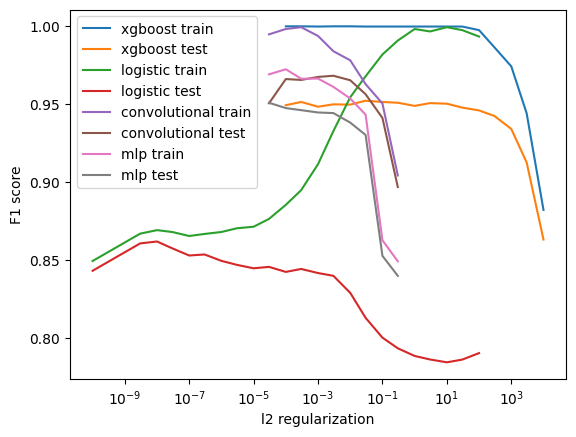

In [52]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_v1.txt")
stats_conv=np.loadtxt("conv2d_4n_v2_full_gal_240.txt")
stats_mlp1=np.loadtxt("mlp_4n_v2_full_gal_240.txt")
stats_mlp2=np.loadtxt("mlp_4n_v2_full_gal_400.txt")
stats_mlp3=np.loadtxt("mlp_4n_v2_full_gal_100.txt")
stats_mlp4=np.loadtxt("mlp_4n_v2b_full_gal_300.txt")
stats_mlp=stats_mlp2.copy()
for i in range(3):
    if stats_mlp4[2,i]>stats_mlp[2,i]:
        stats_mlp[0:5,i]=stats_mlp4[0:5,i]

stats_mlp[0:5,7]=stats_mlp3[0:5]
#looks o.k. but not clear whether minimum is fund real could be at lower regularization
#clearer in log loss
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
#plt.plot(stats_mlp[0],stats_mlp1[1],label='mlp train')
#plt.plot(stats_mlp[0],stats_mlp1[2],label='mlp test')
plt.plot(stats_mlp[0],stats_mlp[1],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[2],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

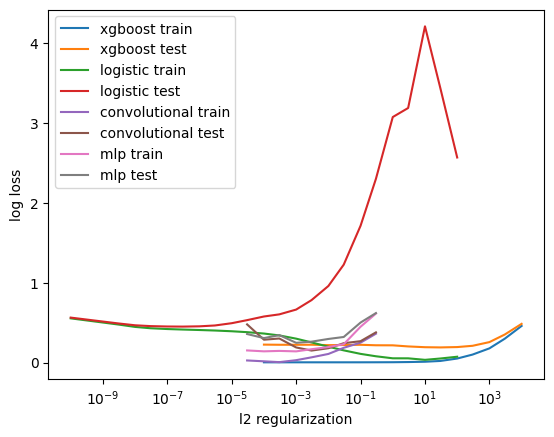

In [53]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.plot(stats_conv[0],stats_conv[3],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[3],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[4],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")

(0.0, 1.0)

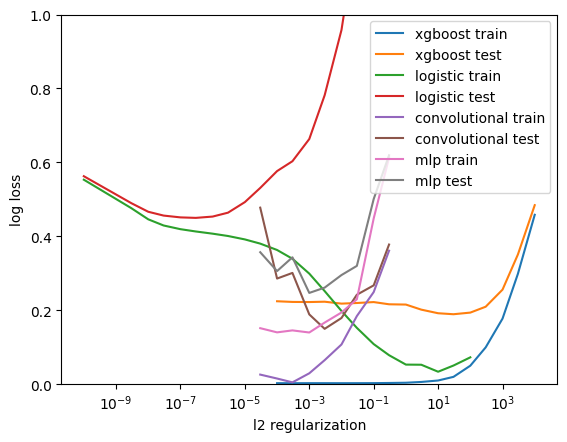

In [55]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.plot(stats_conv[0],stats_conv[3],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[3],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[4],label='mlp test')
#plt.plot(stats_mlp2[0],stats_mlp2[3],label='mlp train 2')
#plt.plot(stats_mlp2[0],stats_mlp2[4],label='mlp test 2')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0,1)

MLP better after 400 runs, but the smallest two regulraizations and maybe the latrgest two have still problems.

at small it jump out of minimum and more the seond large it is likely better to only fit in its own regularization. 